In [1]:
!pip3 install pyclustering prettytable

In [36]:
import os

import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer
from utilities import *
from sklearn.decomposition import PCA
from utilities import heatmap

In [37]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'
if not os.path.exists(DATA_PATH):
    DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'
    if not os.path.exists(DATA_PATH):
        !cp './utilities.py' '/content/drive/MyDrive/code/utilities.py'

        from google.colab import drive

        drive.mount('/content/drive')

        DATA_PATH = '/content/drive/Shareddrives/DM_tweets/data/'
        !cp '/content/drive/MyDrive/code/utilities.py' '.'


In [38]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [39]:
def get_metrics(data_scaled, labels, print_out=True):
    silohuette = metrics.silhouette_score(data_scaled, labels)
    DBscore = metrics.davies_bouldin_score(data_scaled, labels)
    if print_out:
        print(f"Silouhette score: {silohuette}")  # [-1, 1] Good when near 1
        print(f"Davies Bouldin score: {DBscore}")  # Good when near 0
    else:
        return silohuette, DBscore


In [40]:
def sse(df, labels):
    sum = 0
    for label in np.unique(labels):
        mean = df[labels==label].mean().values
        row_sums = df.apply(lambda row: np.linalg.norm(row.values - mean)**2,axis=1).sum()
        print(row_sums)
        sum += np.sum(row_sums)
    return sum

In [95]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None, filename=None, filter=None, figsize=(7,5)):
    plt.figure(figsize=figsize)
    #cent = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(df[attr1], df[attr2], c=c_labels)

    if filter:
        df = df.loc[filter]
        c_labels = c_labels[filter]

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')

    plt.tick_params(axis='both', which='major')

    plt.savefig(filename)


In [155]:
def plots(df, labels, path=None, centroids=None, attributes=None):
  if attributes is None:
    attributes = df.columns

  try:
      os.mkdir(path)
  except FileExistsError:
      pass

  # Line plot
  plt.figure(figsize=(50, 5))
  for label in np.unique(labels):
    if centroids is None:
      cent = df[attributes][labels == label].median()
    else:
      cent = centroids[label]
    plt.plot(cent, label="Cluster %s" % label)
  plt.tick_params(axis='both', which='major')
  plt.xticks(range(0, len(df[attributes].columns)), df[attributes].columns)
  plt.legend()
  if path is not None:
    plt.savefig(path + "/landscape.png")
  else:
      plt.show()

  # Radar plot
  N = len(attributes)

  plt.figure(figsize=(8, 8))
  for label in np.unique(labels):
      angles = [n / float(N) * 2 * math.pi for n in range(N)]
      if centroids is None:
        values = df[attributes].loc[np.where(labels == label)].median().tolist()
      else:
        values = centroids[label].tolist()
      values += values[:1]
      angles += angles[:1]

      ax = plt.subplot(polar=True)
      plt.xticks(angles[:-1], attributes)
      ax.plot(angles, values, linewidth=2)
      ax.fill(angles, values, 'b', alpha=0.1)

  plt.savefig(path + "/radar.png")

  # Plot w.r.t. languages
  lang_ct = pd.crosstab(labels, df['lang'])

  fig, ax = plt.subplots(figsize=(24, 8))
  lang_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('lang')
  plt.yscale('log')
  plt.legend(prop={'size': 15})
  plt.savefig(path + "/lang_characterization.png")

  # Plot w.r.t. bots
  bot_ct = pd.crosstab(labels, df['bot'])

  fig, ax = plt.subplots(figsize=(24, 8))  # Sample figsize in inches
  #plt.figure(figsize=(10,25))
  bot_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('bot')
  plt.legend(prop={'size': 30})
  plt.savefig(path + "/bot_characterization.png")


In [43]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          140543 non-null  int64  
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

In [44]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [45]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                11508 non-null  object 
 1   name                              11507 non-null  object 
 2   lang                              11508 non-null  object 
 3   bot                               11508 non-null  int64  
 4   user_subscription                 11508 non-null  object 
 5   statuses_count                    11508 non-null  float64
 6   user_subscription_in_secs         11508 non-null  int64  
 7   user_id                           11504 non-null  object 
 8   n_tweets                          11504 non-null  float64
 9   2012_tweets                       11504 non-null  float64
 10  2013_tweets                       11504 non-null  float64
 11  2014_tweets                       11504 non-null  float64
 12  2015

Drop categorical columns

In [46]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'user_subscription', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
date_attributes = ['user_subscription_in_secs','publication_date_in_secs_mean','publication_date_in_secs_std']
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

We try to understand which attributes should be transformed in log scale by analyzing the boxplots

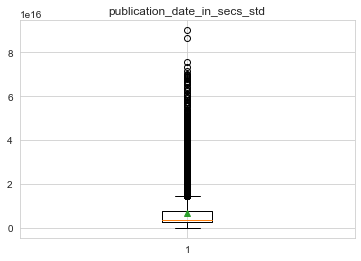

In [47]:
plot_boxplot(df_merge, 'publication_date_in_secs_std')

<AxesSubplot:>

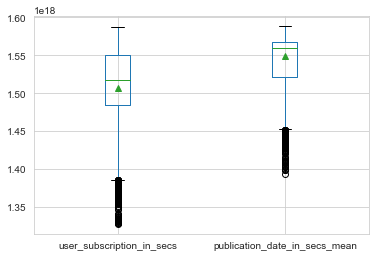

In [48]:
df_merge[['user_subscription_in_secs','publication_date_in_secs_mean']].boxplot(showmeans=True)

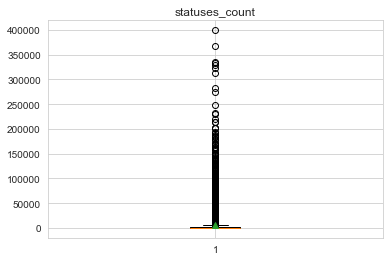

In [49]:
plot_boxplot(df_merge, 'statuses_count')

<AxesSubplot:>

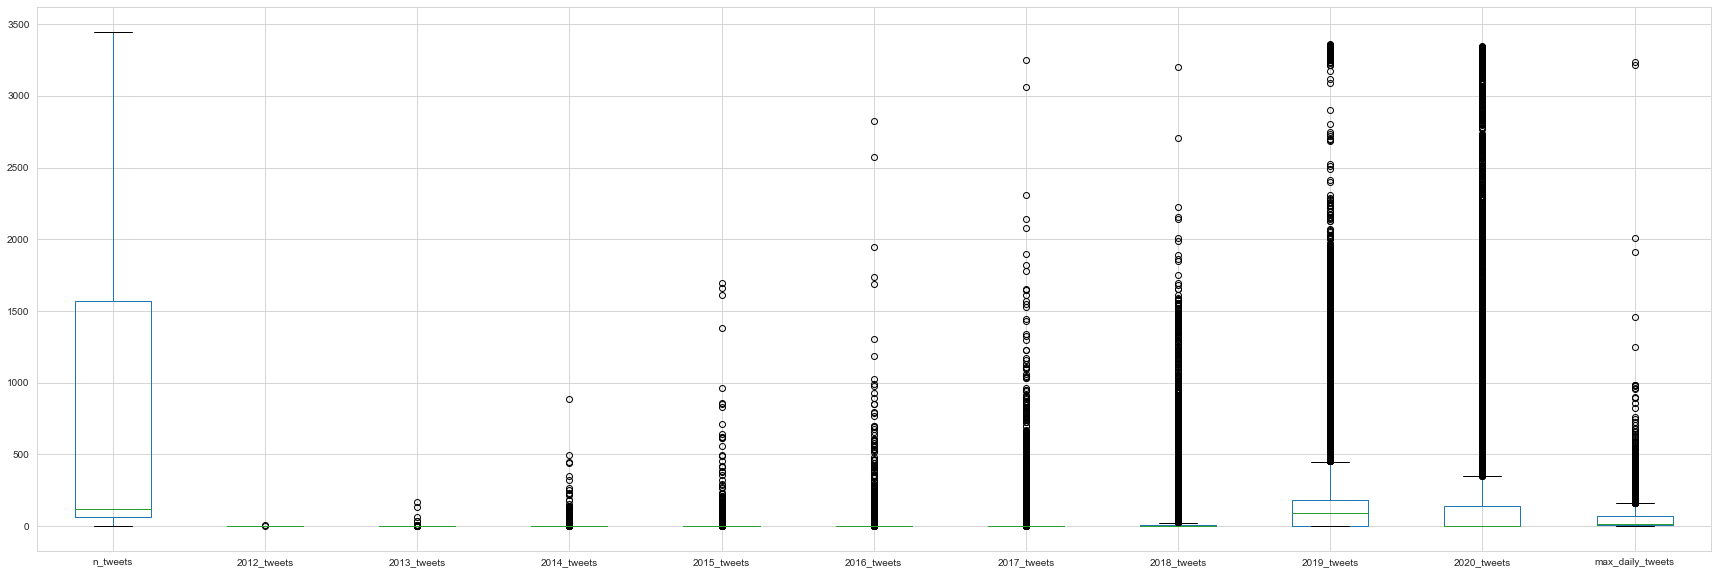

In [50]:
n_tweets_attrs = [attr for attr in df_merge.columns if '_tweets' in attr and 'density' not in attr]
plt.figure(figsize=(30, 10))
df_merge.boxplot(n_tweets_attrs)

<AxesSubplot:>

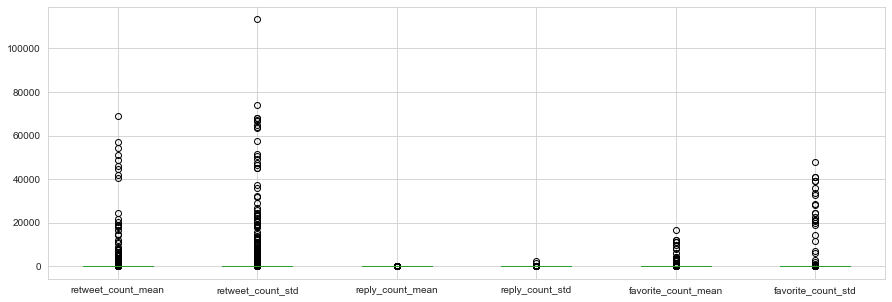

In [51]:
mean_count_attrs = [attr for attr in df_merge.columns if 'count_mean' in attr or  'count_std' in attr]
plt.figure(figsize=(15, 5))
df_merge.boxplot(mean_count_attrs)

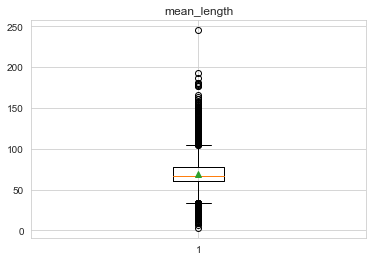

In [18]:
plot_boxplot(df_merge, 'mean_length')

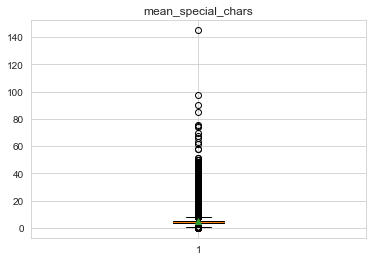

In [52]:
plot_boxplot(df_merge, 'mean_special_chars')

<AxesSubplot:>

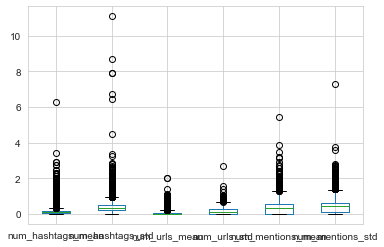

In [53]:
tweet_stats_attributes = ['num_hashtags_mean','num_hashtags_std','num_urls_mean','num_urls_std','num_mentions_mean','num_mentions_std']
df_merge.boxplot(tweet_stats_attributes)

C:\Users\al\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


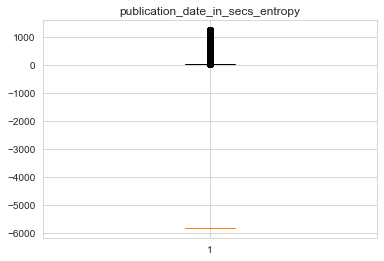

In [54]:
plot_boxplot(df_merge, 'publication_date_in_secs_entropy')

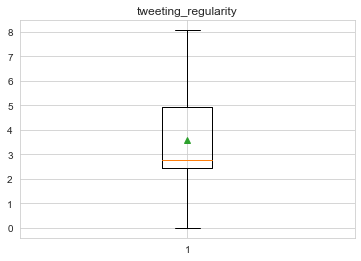

In [55]:
plot_boxplot(df_merge, 'tweeting_regularity')

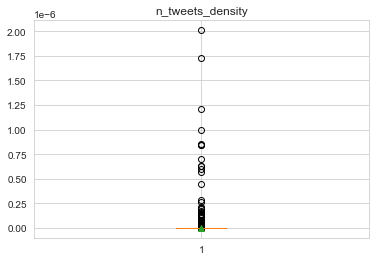

In [56]:
plot_boxplot(df_merge, 'n_tweets_density')

<AxesSubplot:>

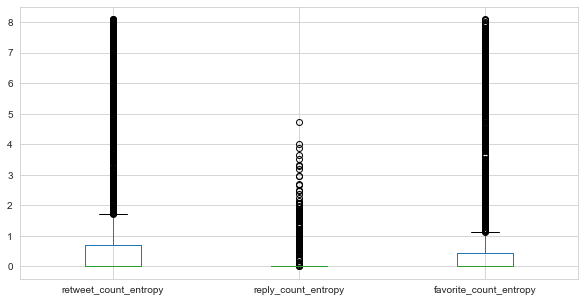

In [58]:
# plot of all the attributes not plotted above, to be sure of not forgetting anything
plt.figure(figsize=(10, 5))
df_merge.boxplot([attr for attr in df_merge.columns if attr not in date_attributes+non_numeric_attributes+['statuses_count','n_tweets','mean_length','tweeting_regularity','publication_date_in_secs_entropy','n_tweets_density','mean_special_chars']+n_tweets_attrs+mean_count_attrs+tweet_stats_attributes])

In [59]:
# To understand which attribute should be transformed in log scale
not_log = tweet_stats_attributes + ['publication_date_in_secs_mean','user_subscription_in_secs', 'mean_length','tweeting_regularity','retweet_count_entropy','reply_count_entropy','favorite_count_entropy','mean_special_chars']
attrs_to_log = [c for c in df_merge.columns if c not in not_log+non_numeric_attributes]

In [60]:
# Select values to log
df_merge_log = df_merge[attrs_to_log]

# Replace NaN values in variance with 0
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_log = df_merge_log.fillna(value=0)

# Normalization of values

In [61]:
def to_log(df, attr):
    df[attr] = np.log(df[attr].values)
    df[attr] = df[attr].replace(-np.inf, 0)
    df[attr] = df[attr].fillna(value=0)
    return df[attr]

In [62]:
for attr in attrs_to_log:
    df_merge_log[attr] = to_log(df_merge_log, attr)

C:\Users\al\AppData\Local\Temp\ipykernel_12592\1059147254.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_12592\1059147254.py:2: RuntimeWarning: invalid value encountered in log
  df[attr] = np.log(df[attr].values)


It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [63]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_log.columns:
    table.add_row([attr, df_merge_log[attr].min(), df_merge_log[attr].max()])
print(table)

+----------------------------------+---------------------+--------------------+
|               attr               |         min         |        max         |
+----------------------------------+---------------------+--------------------+
|          statuses_count          |         0.0         | 12.898106706802647 |
|             n_tweets             |         0.0         | 8.145259566516865  |
|           2012_tweets            |         0.0         | 1.9459101490553132 |
|           2013_tweets            |         0.0         | 5.1298987149230735 |
|           2014_tweets            |         0.0         | 6.785587645007929  |
|           2015_tweets            |         0.0         | 7.436617265234227  |
|           2016_tweets            |         0.0         | 7.945909598613133  |
|           2017_tweets            |         0.0         | 8.086410275323782  |
|           2018_tweets            |         0.0         |  8.07153089355666  |
|           2019_tweets            |    

In [64]:
# Normalizzare i valori in log
df_merge_log[not_log] = df_merge[not_log]
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)

In [65]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_scaled.columns:
    table.add_row([attr, df_merge_scaled[attr].min(), df_merge_scaled[attr].max()])
print(table)

+----------------------------------+-----+--------------------+
|               attr               | min |        max         |
+----------------------------------+-----+--------------------+
|          statuses_count          | 0.0 |        1.0         |
|             n_tweets             | 0.0 |        1.0         |
|           2012_tweets            | 0.0 |        1.0         |
|           2013_tweets            | 0.0 |        1.0         |
|           2014_tweets            | 0.0 | 0.9999999999999999 |
|           2015_tweets            | 0.0 | 0.9999999999999999 |
|           2016_tweets            | 0.0 |        1.0         |
|           2017_tweets            | 0.0 |        1.0         |
|           2018_tweets            | 0.0 |        1.0         |
|           2019_tweets            | 0.0 |        1.0         |
|           2020_tweets            | 0.0 |        1.0         |
|   publication_date_in_secs_std   | 0.0 |        1.0         |
| publication_date_in_secs_entropy | 0.0

In [66]:
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [67]:
df_merge_scaled.fillna(0, inplace=True)

In [116]:
df_merge[numeric_attributes].fillna(0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   statuses_count                    11508 non-null  float64
 1   user_subscription_in_secs         11508 non-null  int64  
 2   n_tweets                          11508 non-null  float64
 3   2012_tweets                       11508 non-null  float64
 4   2013_tweets                       11508 non-null  float64
 5   2014_tweets                       11508 non-null  float64
 6   2015_tweets                       11508 non-null  float64
 7   2016_tweets                       11508 non-null  float64
 8   2017_tweets                       11508 non-null  float64
 9   2018_tweets                       11508 non-null  float64
 10  2019_tweets                       11508 non-null  float64
 11  2020_tweets                       11508 non-null  float64
 12  mean

# PCA

In [117]:
df_merge_scaled[['pc1_scaled','pc2_scaled']] = PCA(n_components=2).fit_transform(df_merge_scaled[numeric_attributes])
df_merge_scaled[['pc1','pc2']] = PCA(n_components=2).fit_transform(df_merge[numeric_attributes].fillna(0))
df_merge_scaled[['pc1','pc2','bot']]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

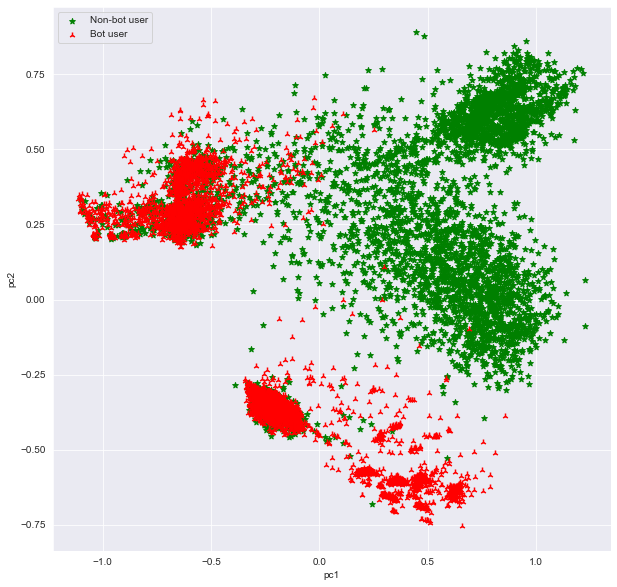

In [118]:
plt.figure(figsize=(10,10))
bot_scatter(df_merge_scaled,'pc1','pc2',path="bot_pca.png")

# DB Scan

In [119]:
try:
  os.mkdir('dbscan')
except:
  pass

In [120]:
dist = pdist(df_merge_scaled[numeric_attributes], 'euclidean')
dist_matrix = squareform(dist)

First we compute the distance matrix to choose the epsilon parameter.
We choose quite a high k since we have a considerably high amount of samples and high dimensionality

In [132]:
distances = list()
k = 10
for d in dist_matrix:
    index_kth_distance = np.argsort(d)[k]
    distances.append(d[index_kth_distance])

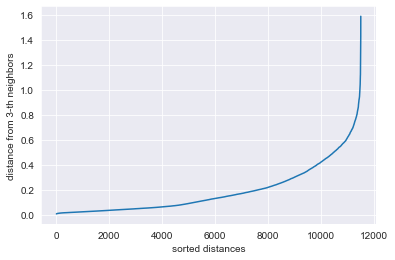

In [133]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')
plt.savefig('dbscan/distances_curve.png')

The knee of the curve is around 0.4, so values around this point will be investigated. Interstingle, our curve bens in the 0.1 neighborhood, hence also this zone is worth investigating.

In [134]:
min_samples = 2*len(numeric_attributes)
min_samples

70

In [136]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.35,0.4,0.45,0.5,0.55,0.6]:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+------+---------------------+--------------------+------------+
| eps  |      silohuette     |      DB score      | n clusters |
+------+---------------------+--------------------+------------+
| 0.35 |  0.2747258162597753 | 1.496702601297147  |     12     |
| 0.4  |  0.3021163638850524 | 1.4789246030091405 |     14     |
| 0.45 |  0.2520024760388601 | 1.6117998439386498 |     12     |
| 0.5  | 0.25275531269074947 | 1.6863755832455263 |     9      |
| 0.55 | 0.15961001172980188 | 1.606735636893206  |     9      |
| 0.6  | 0.12401799908576386 |  1.78476498096284  |     6      |
+------+---------------------+--------------------+------------+


In [137]:
dbscan = DBSCAN(eps=0.4, min_samples=min_samples)
clusters = dbscan.fit(df_merge_scaled[numeric_attributes])

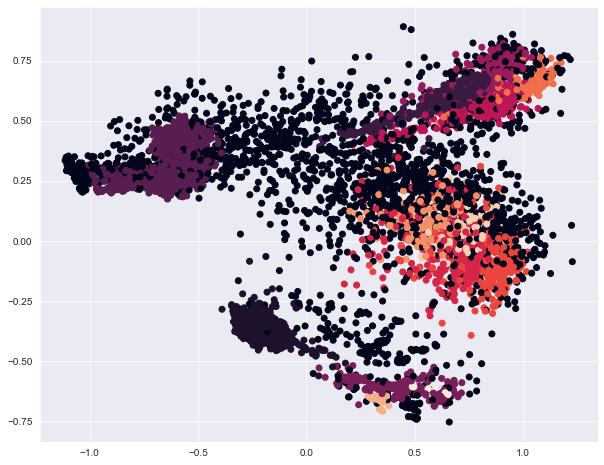

In [138]:
scatterplot(df_merge_scaled, 'pc1', 'pc2', clusters.labels_, filename="dbscan/scatter.png", figsize=(10,8))

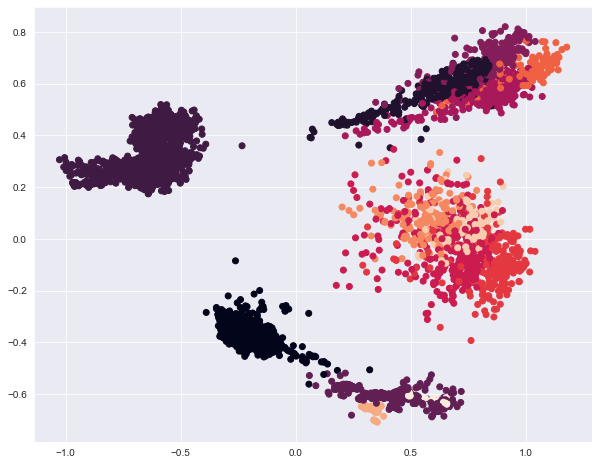

In [139]:
scatterplot(df_merge_scaled[clusters.labels_ != -1], 'pc1', 'pc2', clusters.labels_[clusters.labels_ != -1], filename="dbscan/scatter.png", figsize=(10,8))

In [140]:
(clusters.labels_==-1).sum()

2426

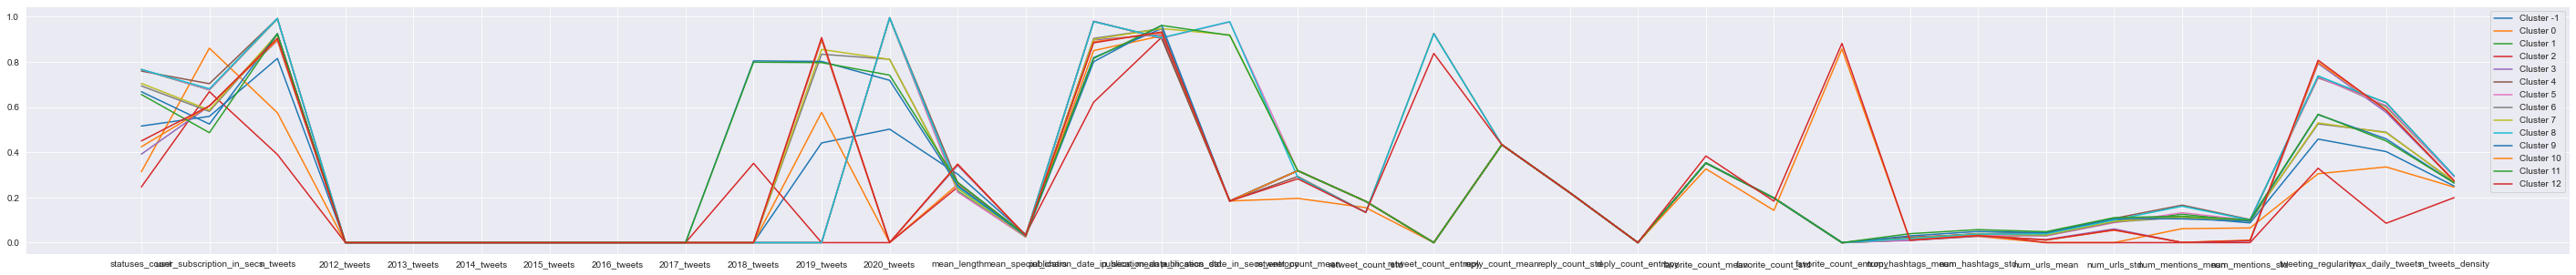

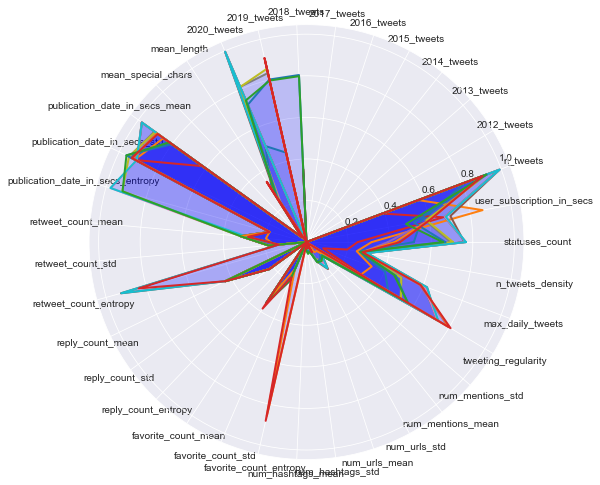

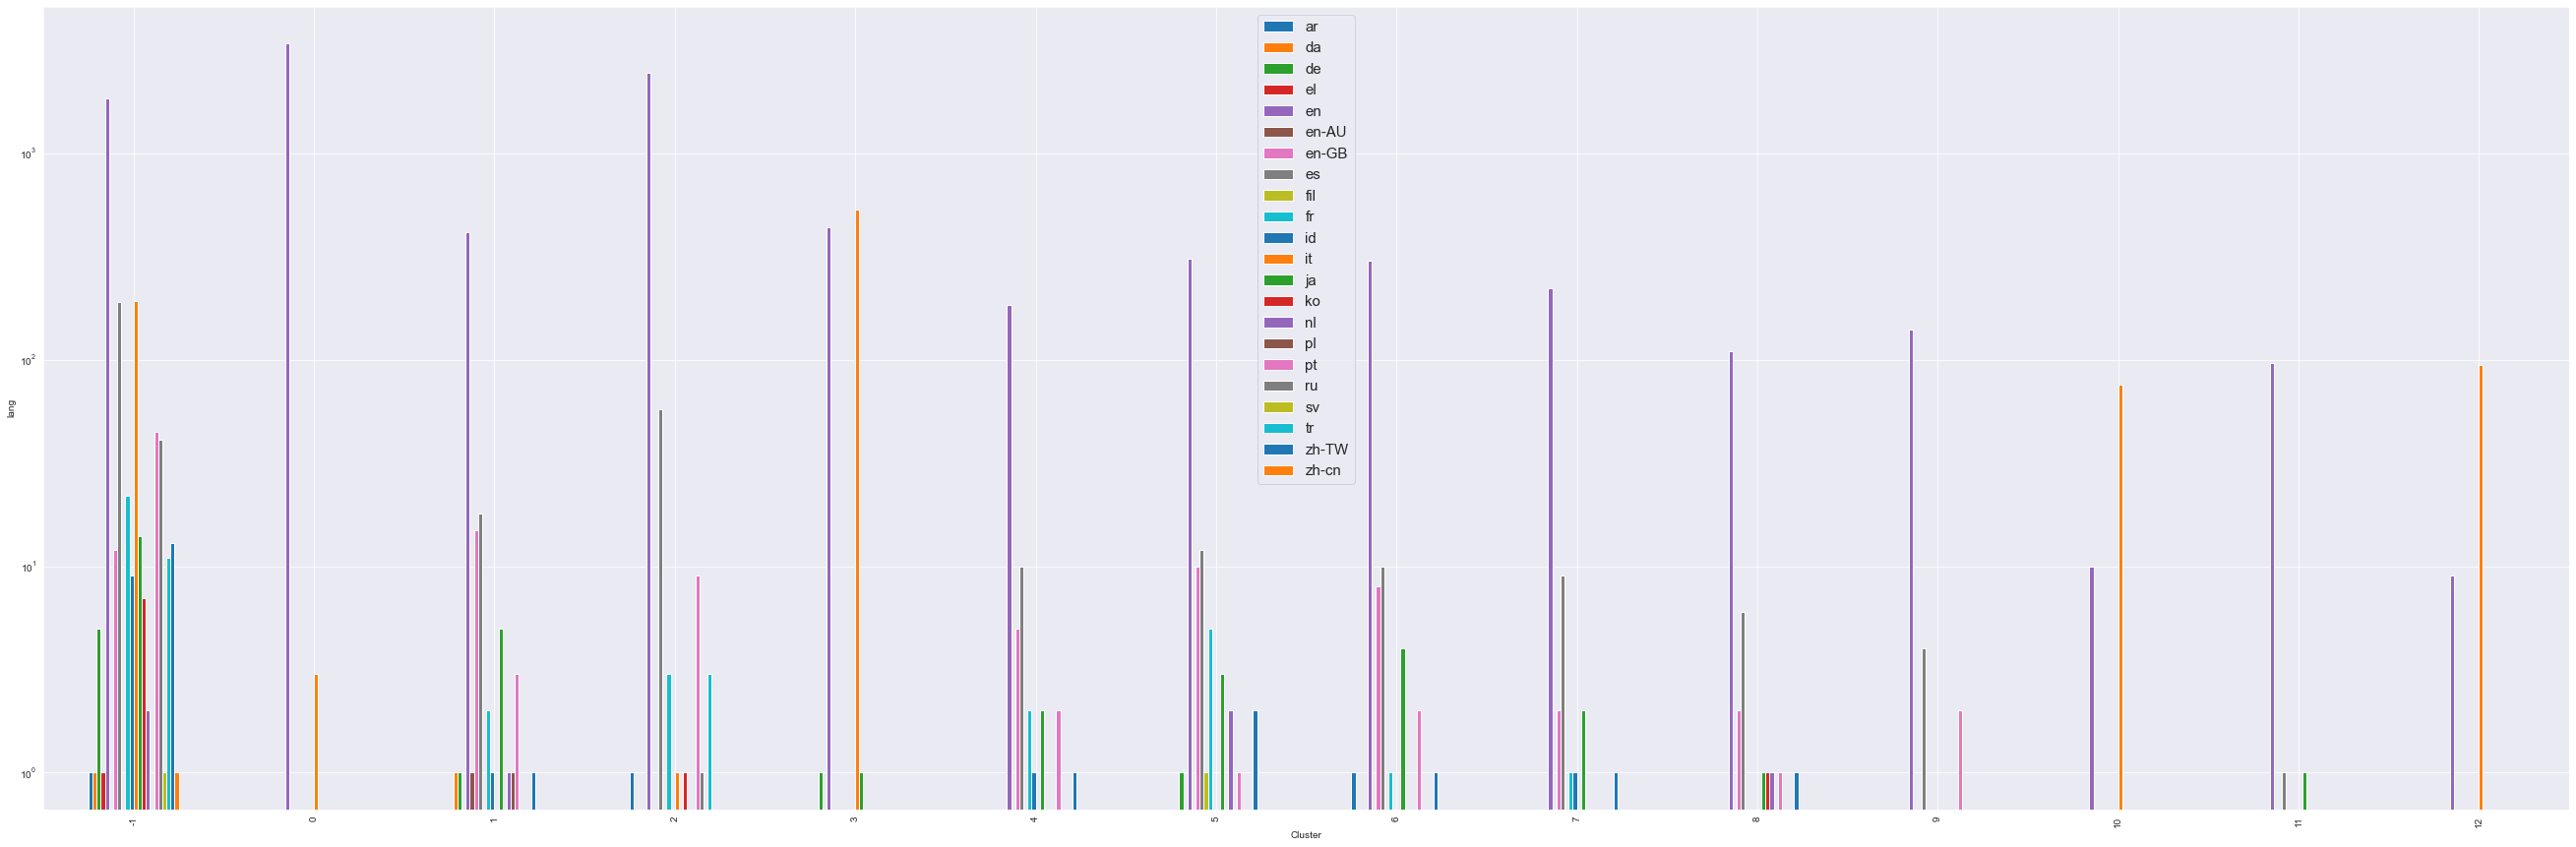

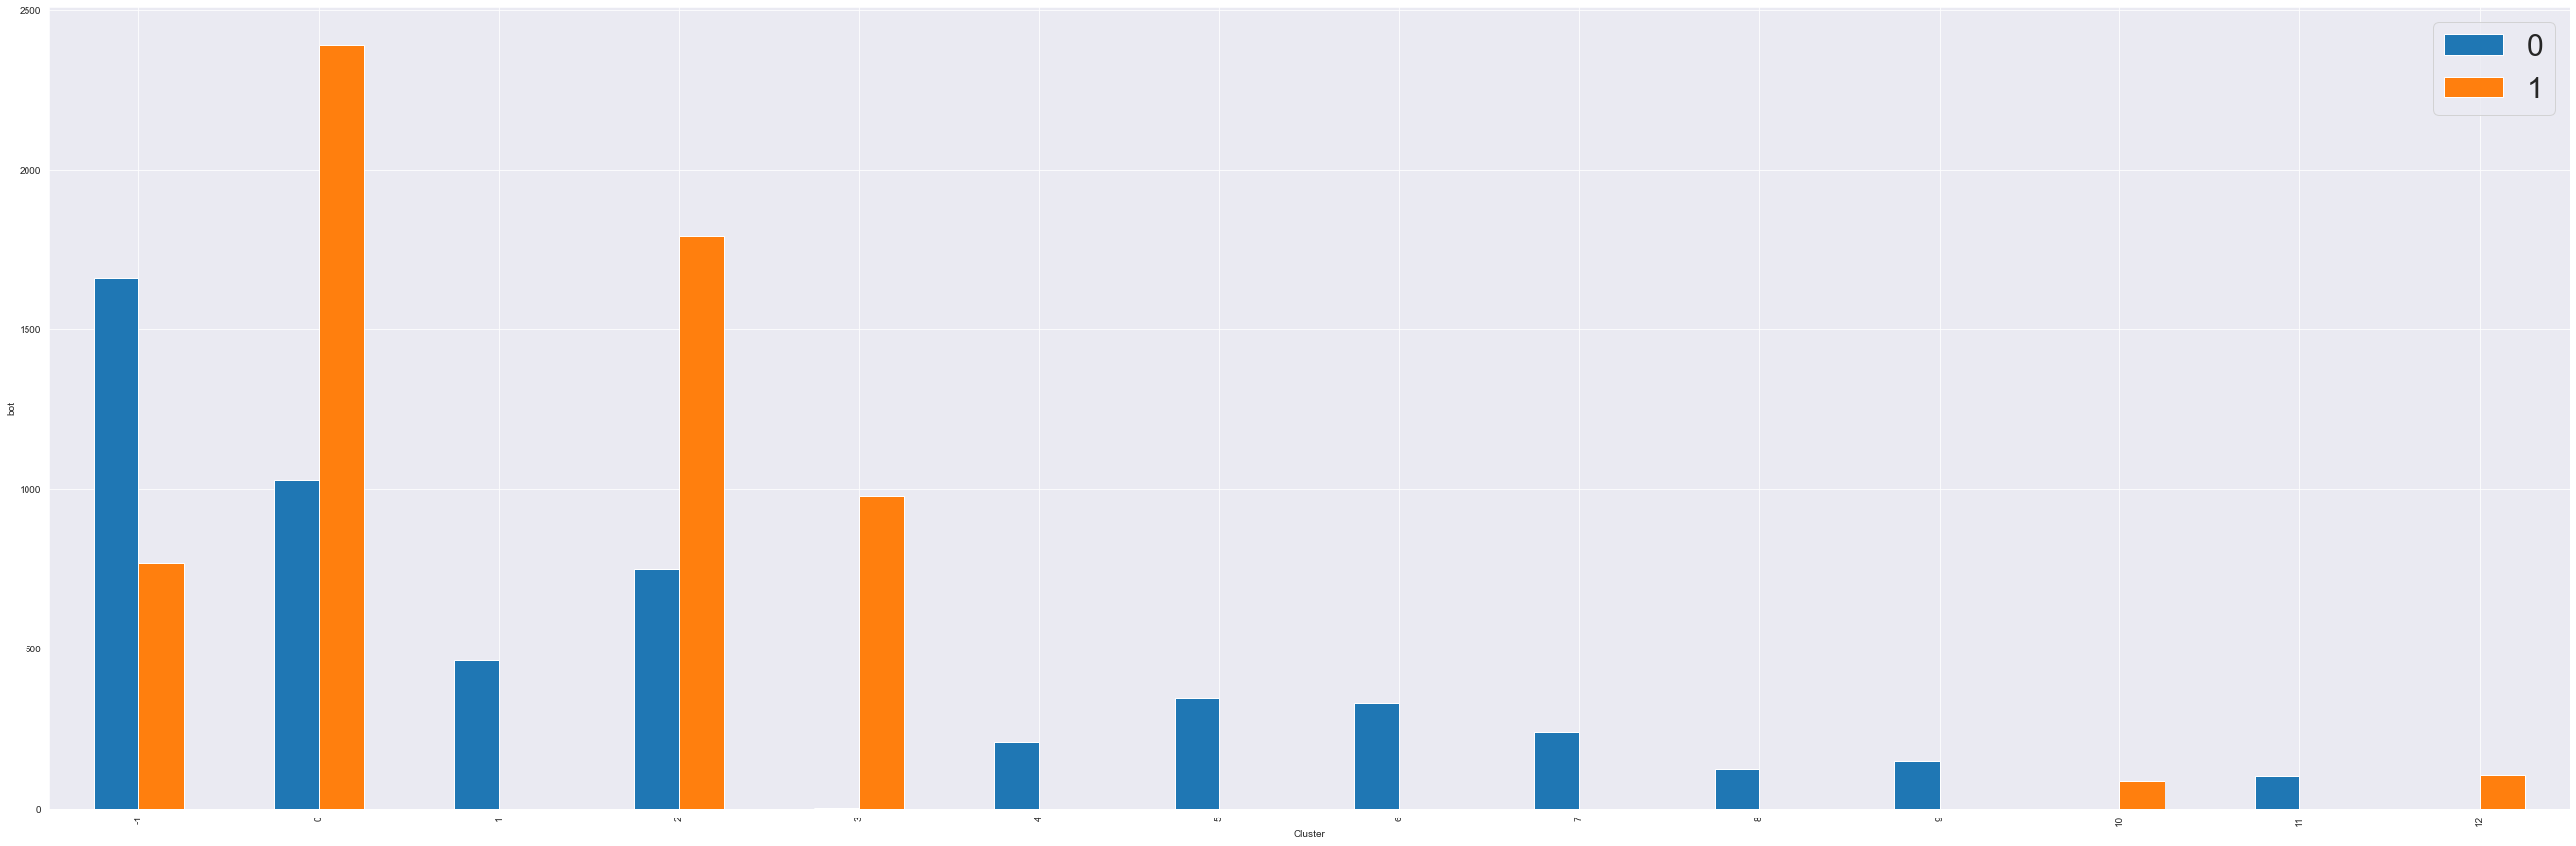

In [141]:
plots(df_merge_scaled, clusters.labels_, path="dbscan", attributes=numeric_attributes)

In [142]:
df_denoised = df_merge_scaled[clusters.labels_!=-1]

# KMeans

In [143]:
try:
  os.mkdir('kmeans')
except:
  pass

K means is run in two ways: with the complete set of users and removing the samples identified as noisy by DBscan

In [144]:
def find_optimal_k(df, max_k=40):
    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(df)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

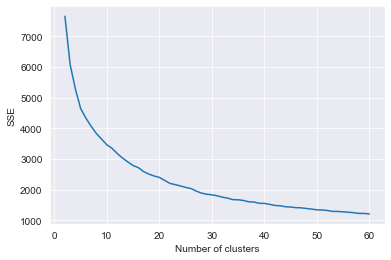

In [149]:
find_optimal_k(df_merge_scaled[numeric_attributes], max_k=60)

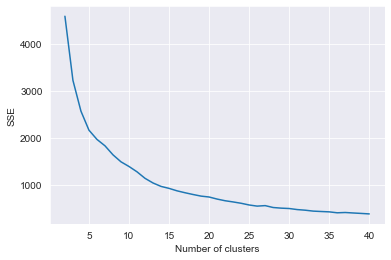

In [146]:
find_optimal_k(df_denoised[numeric_attributes])

The optimal number of clusters seems to be around 10.

In [153]:
def kmeans_analysis(df, k, n_init=20, max_iter=300, out_dir=None, combinations=False):
    try:
        os.mkdir(out_dir)
    except FileExistsError:
        pass

    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(df[numeric_attributes])
    cent = kmeans.cluster_centers_

    print(f'SSE:', kmeans.inertia_)
    print(f'mySSE:', sse(df[numeric_attributes], kmeans.labels_))
    get_metrics(df[numeric_attributes], kmeans.labels_)

    if combinations:
        try:
            os.mkdir(os.path.join(out_dir, 'combinations'))
        except FileExistsError:
            pass
        combs = combinations(df[numeric_attributes].columns, 2)
        os.mkdir('kmeans')
        os.mkdir('kmeans/log_denoised')
        for comb in combs:
            plt.ylabel(comb[1])
            plt.xlabel(comb[0])
            print(*comb)
            scatterplot(df, *comb, kmeans.labels_, centroids=cent,
                        filename=os.path.join(out_dir, 'combinations', f"scatterplot_{comb[1]}_{comb[0]}.png"))
    else:
        scatterplot(df, 'pc1', 'pc2', kmeans.labels_,
                    centroids=cent, filename=os.path.join(out_dir, "clusters"))

    plots(df, kmeans.labels_, path = out_dir, centroids = cent, attributes=numeric_attributes)

SSE: 3472.5834056643603
18727.51726054195
12880.930985641107
18011.419425155455
16658.711606093548
18248.87716969615
25699.790983766292
25525.238151376536
25359.01698755702
20159.436945405738
22629.050957585147
mySSE: 203899.99047281896
Silouhette score: 0.354459611111439
Davies Bouldin score: 1.441958814299288


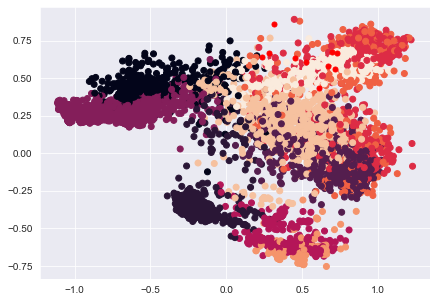

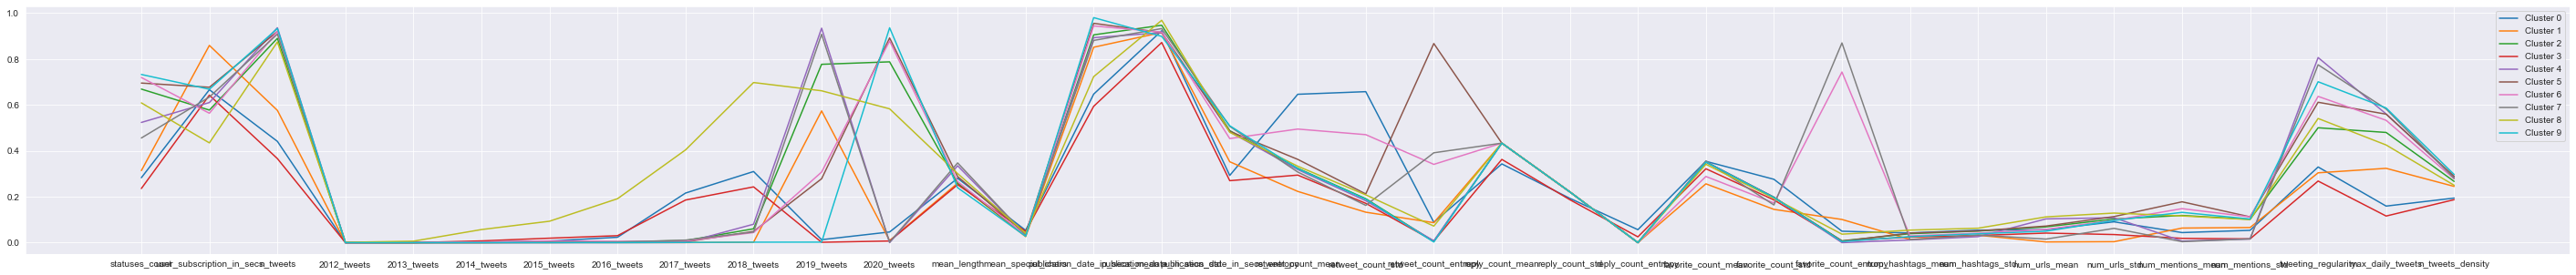

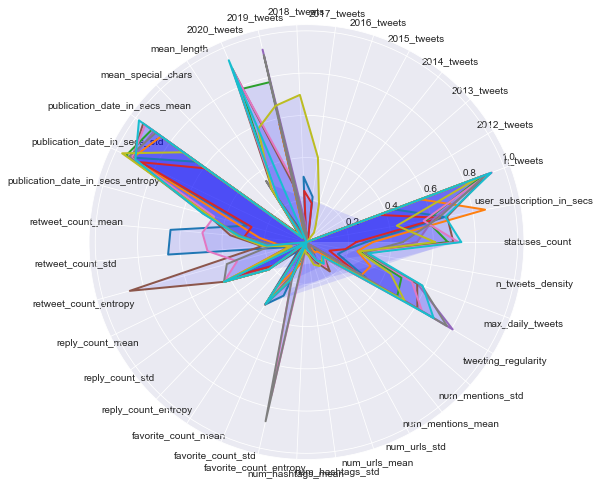

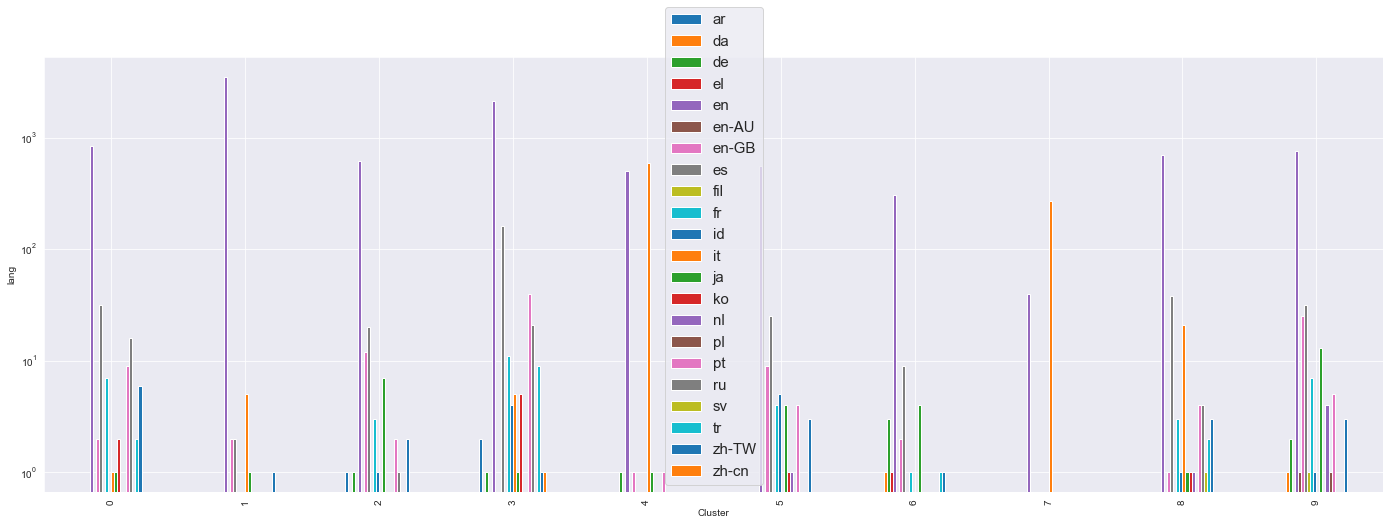

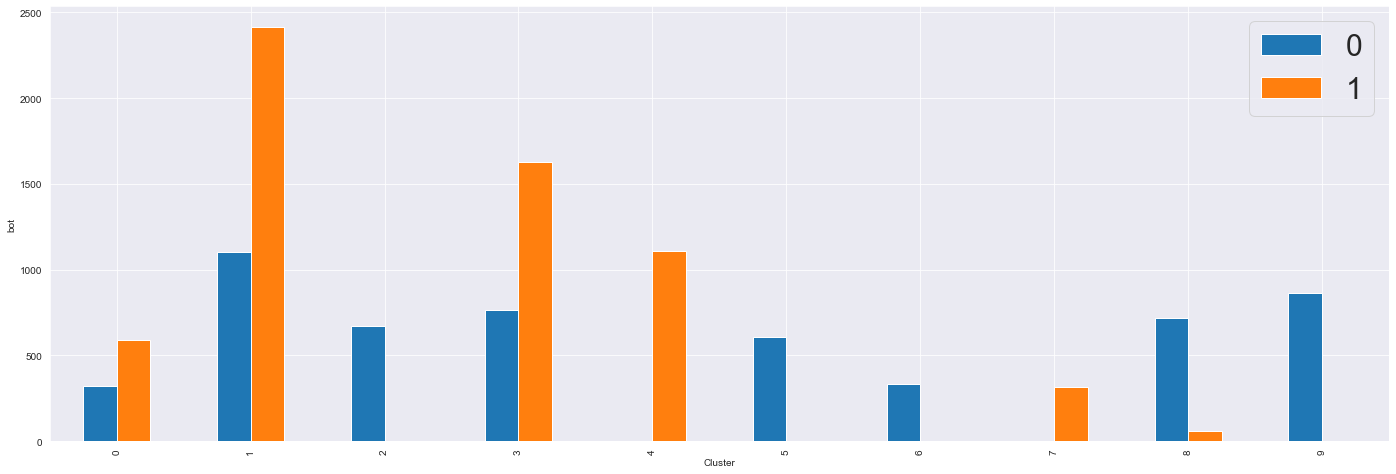

In [156]:
kmeans_analysis(df_merge_scaled, k=10, out_dir='kmeans/scaled_k10')

SSE: 3214.1212318498233
21443.352095967053
18629.48761020713
16431.35012013562
12891.249434297604
25899.034455328103
17856.1068041254
25370.422084014193
23197.867769993616
21663.864146845885
21259.018814897412
18809.560200297634
34497.91073859107
mySSE: 257949.2242747007
Silouhette score: 0.3644772578931349
Davies Bouldin score: 1.386752857633626


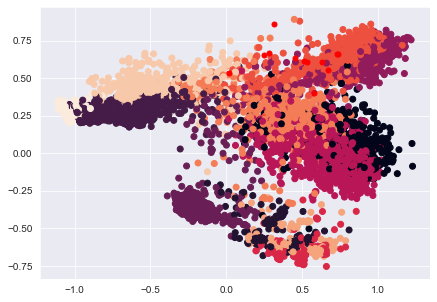

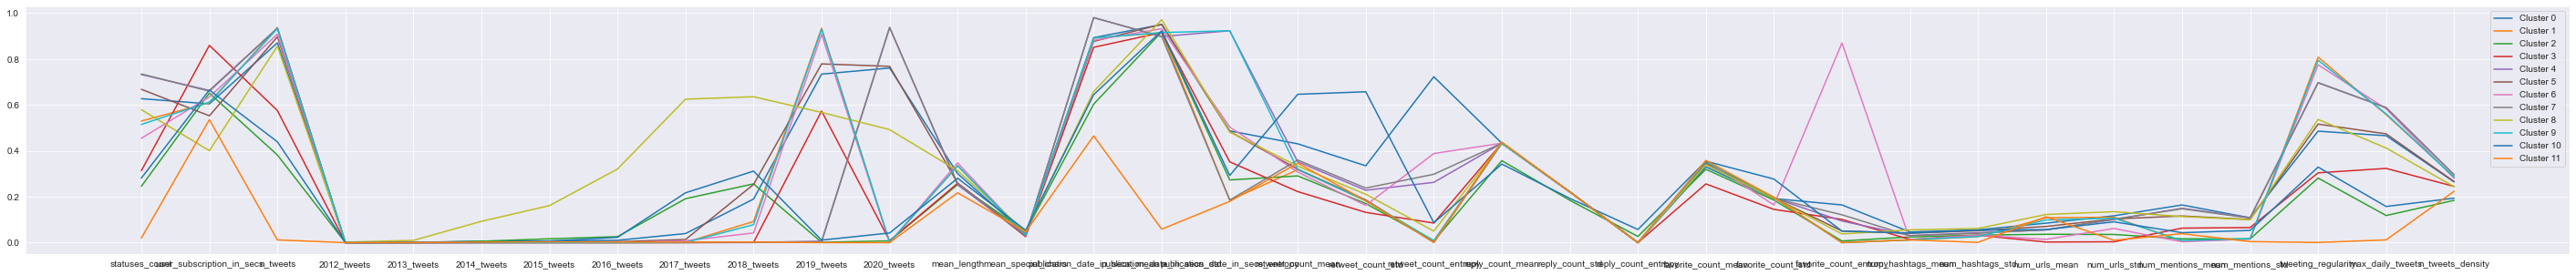

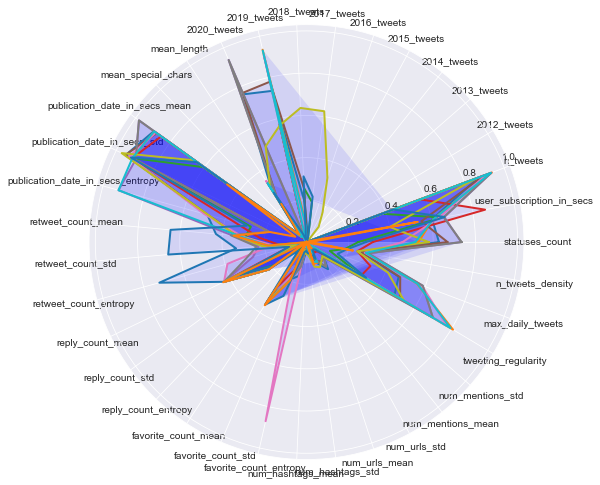

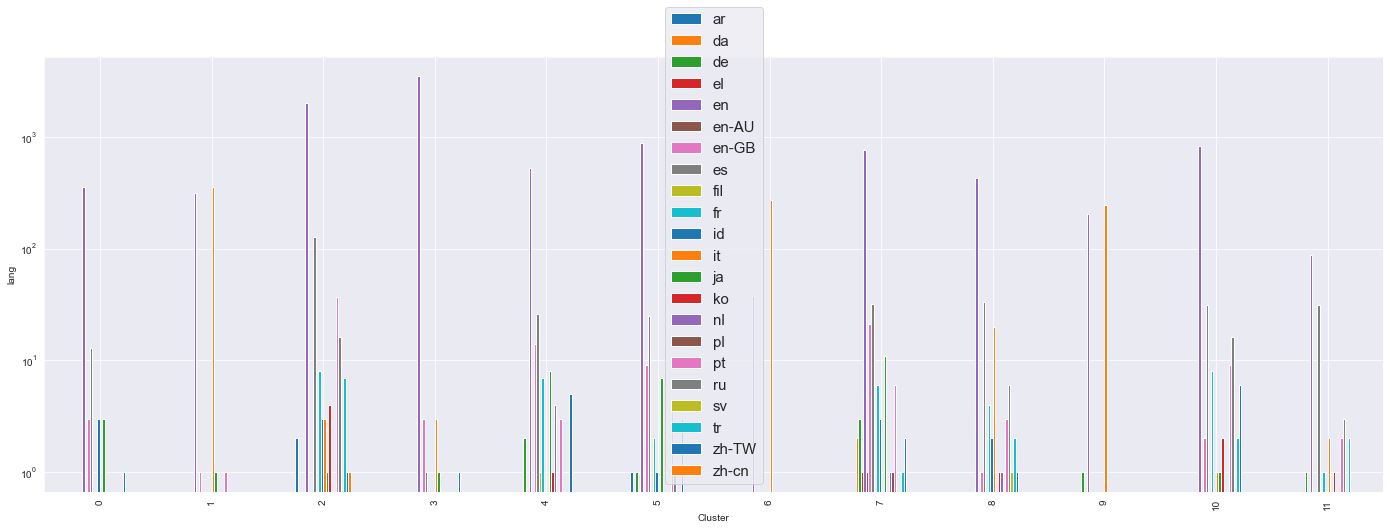

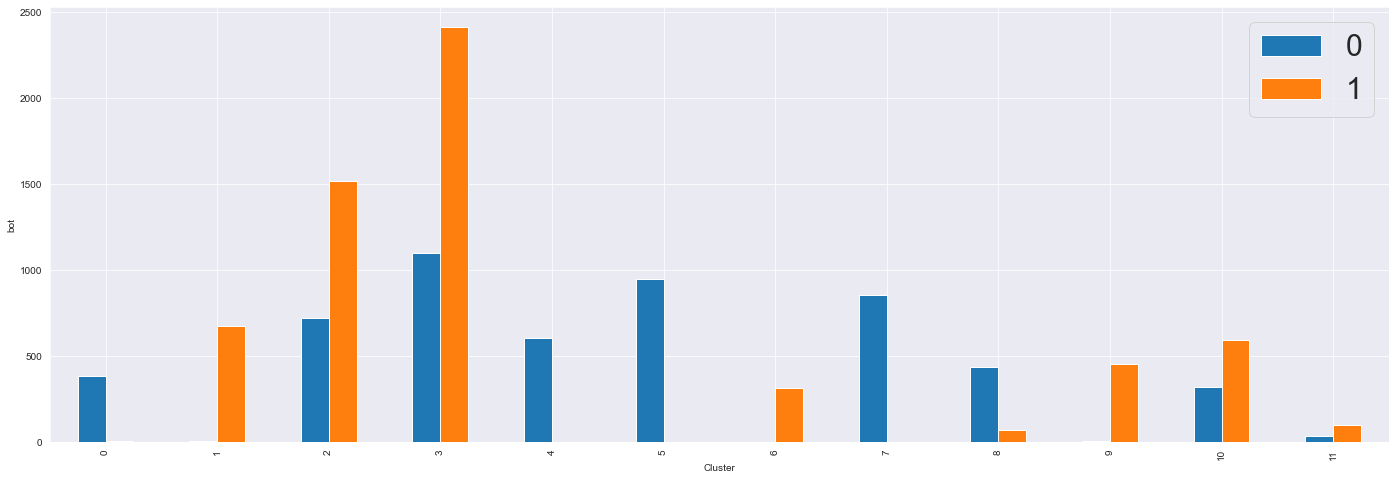

In [157]:
kmeans_analysis(df_merge_scaled, k=12, out_dir='kmeans/scaled_k12')

SSE: 1769.7935573778402
17468.02523271736
8154.353799709031
13723.078674592301
14049.119671924827
12732.993789826167
11355.671451541453
24220.98644465777
mySSE: 101704.22906496891
Silouhette score: 0.43051745089040966
Davies Bouldin score: 1.20350771644468


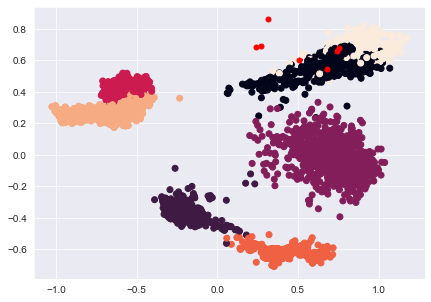

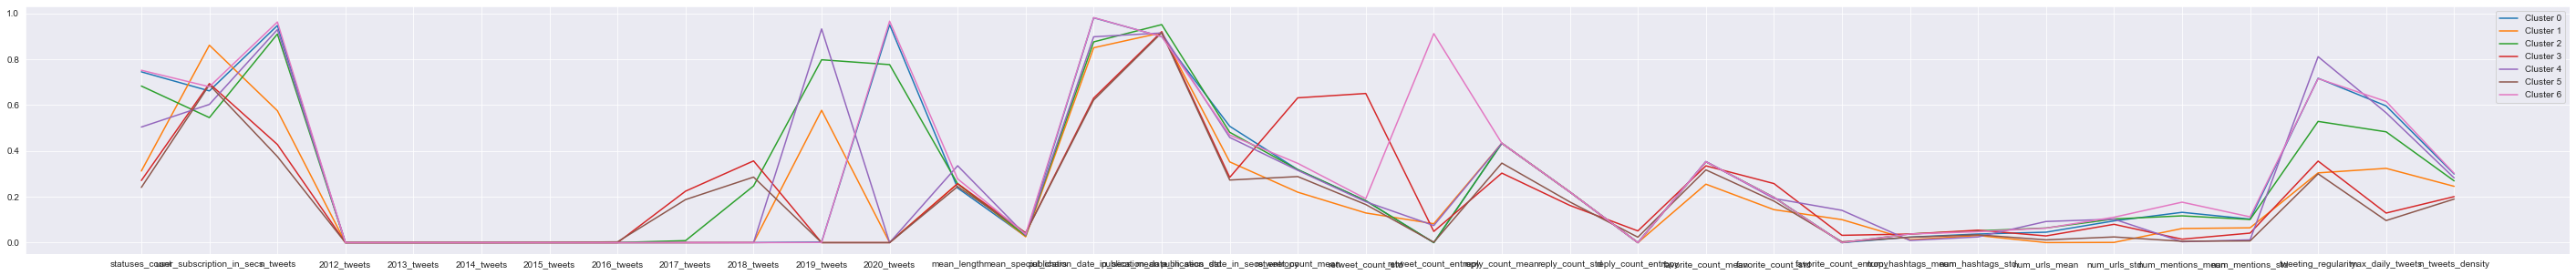

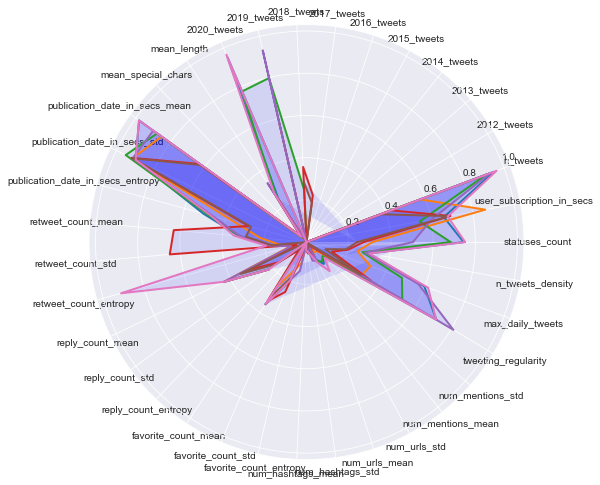

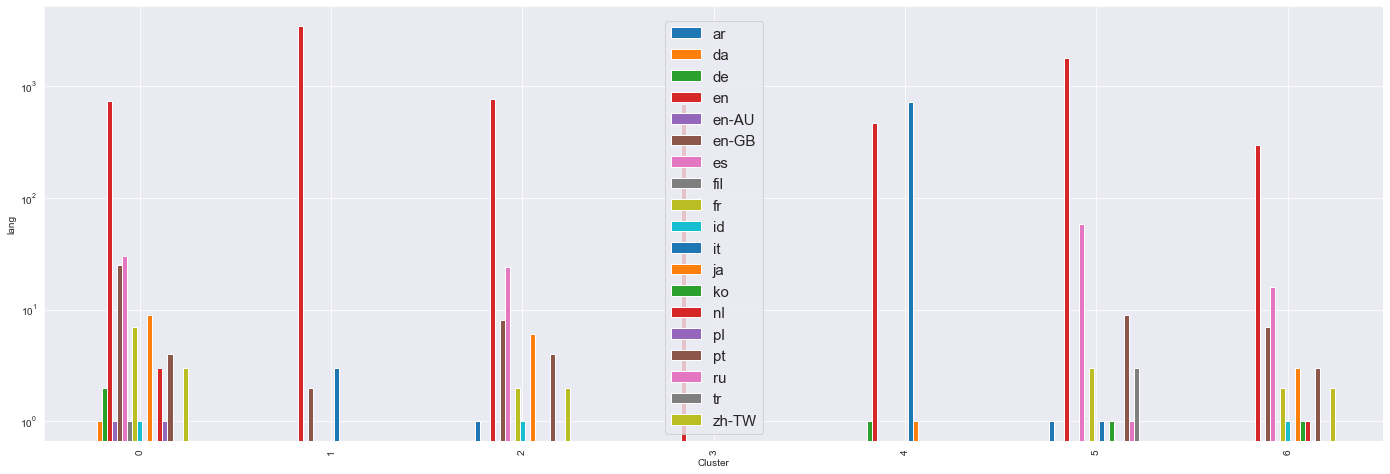

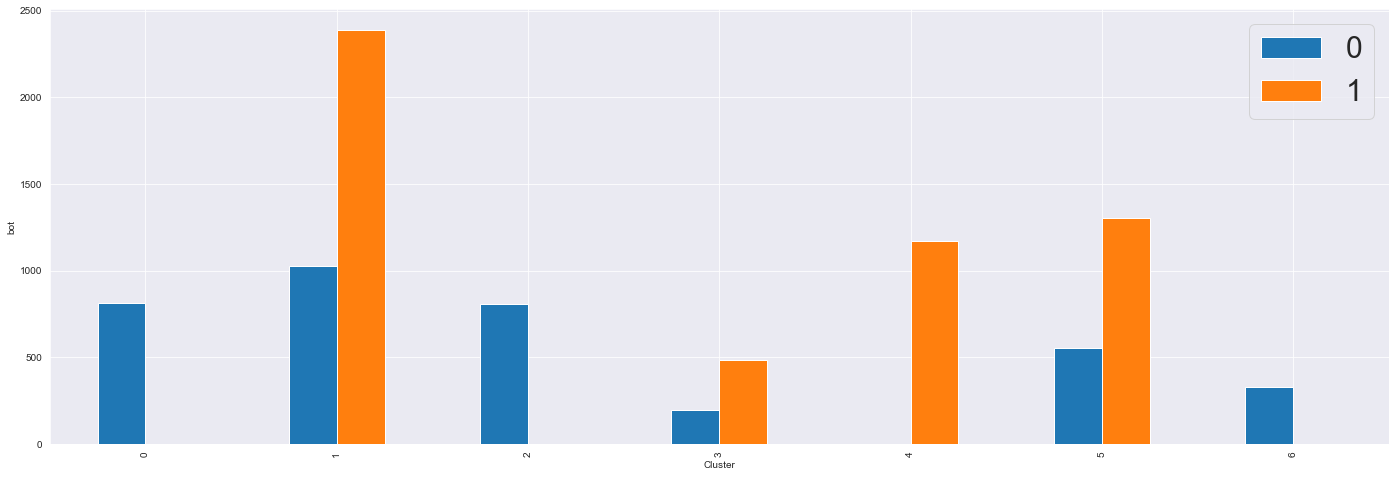

In [158]:
kmeans_analysis(df_denoised, k=7, out_dir='kmeans/denoised_k7')

SSE: 1620.3416561200474
8154.68596028816
17493.513873885415
14049.119671924827
13036.847100014413
11355.671451541453
13711.609763978277
15287.314235358679
24220.98644465777
mySSE: 117309.748501649
Silouhette score: 0.444611207528127
Davies Bouldin score: 1.1513590529515154


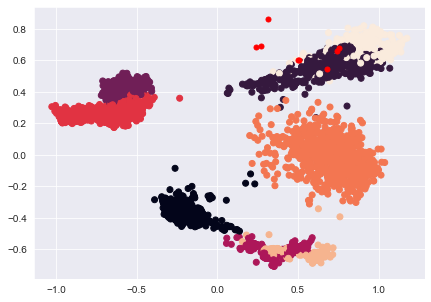

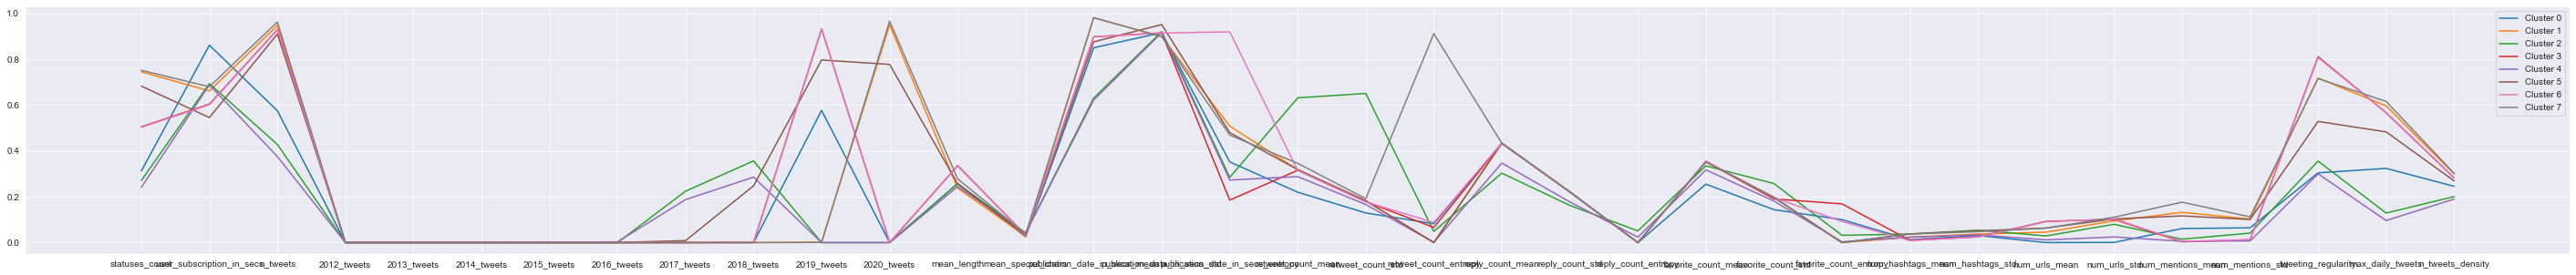

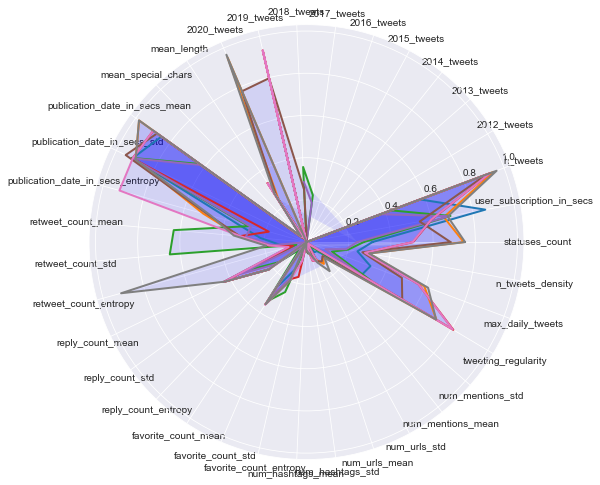

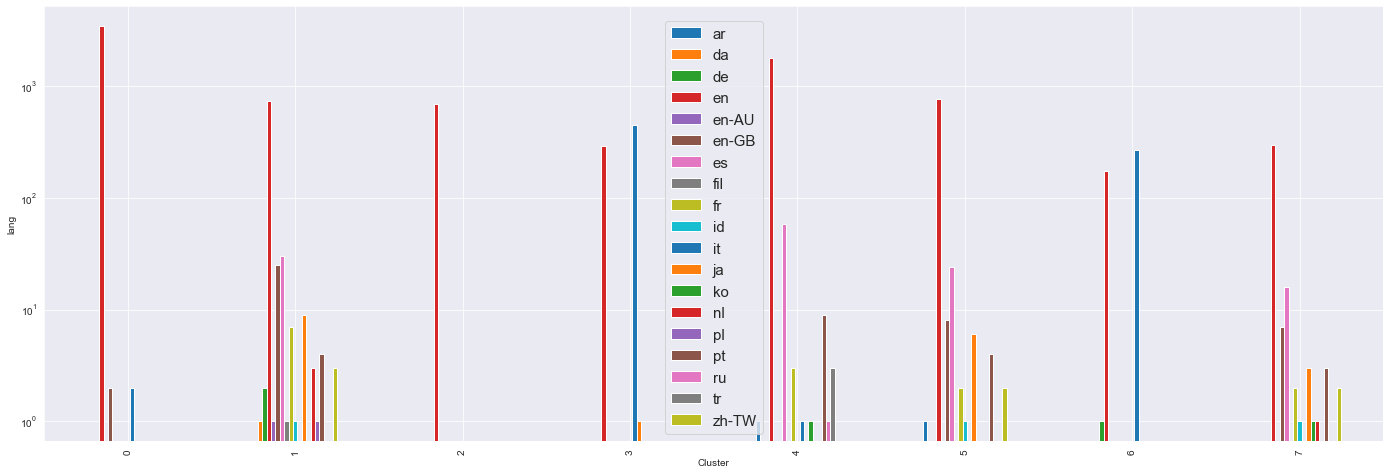

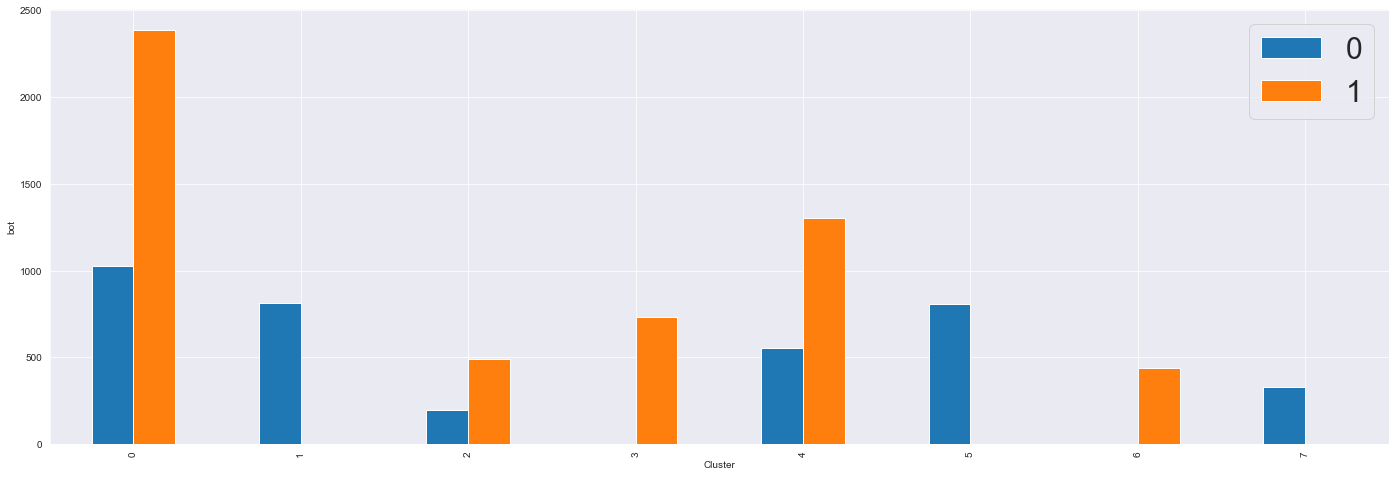

In [159]:
kmeans_analysis(df_denoised, k=8, out_dir='kmeans/denoised_k8')

SSE: 1532.1279759076795
11355.671451541453
16190.679475793688
8575.20873981553
24220.98644465777
12736.779713931806
17518.21502756257
8478.564962498021
13839.683236306642
14049.119671924827
mySSE: 126964.90872403231
Silouhette score: 0.3618428537723931
Davies Bouldin score: 1.202236314341559


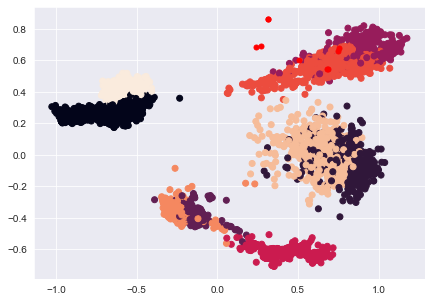

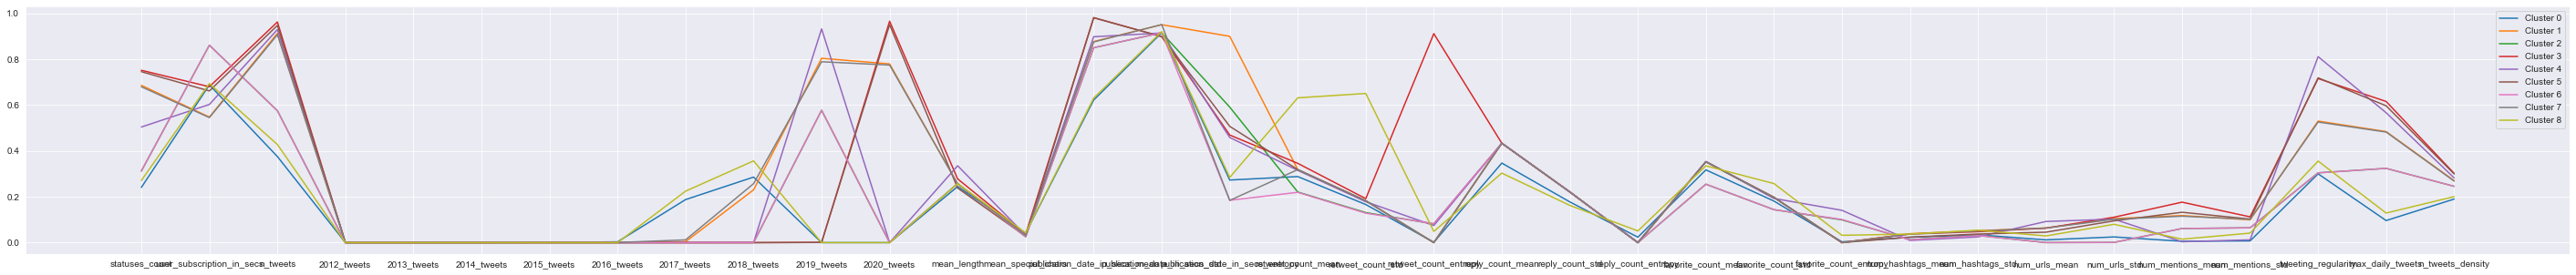

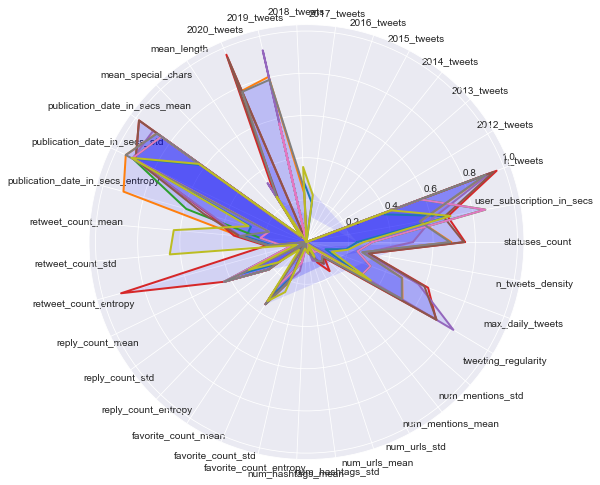

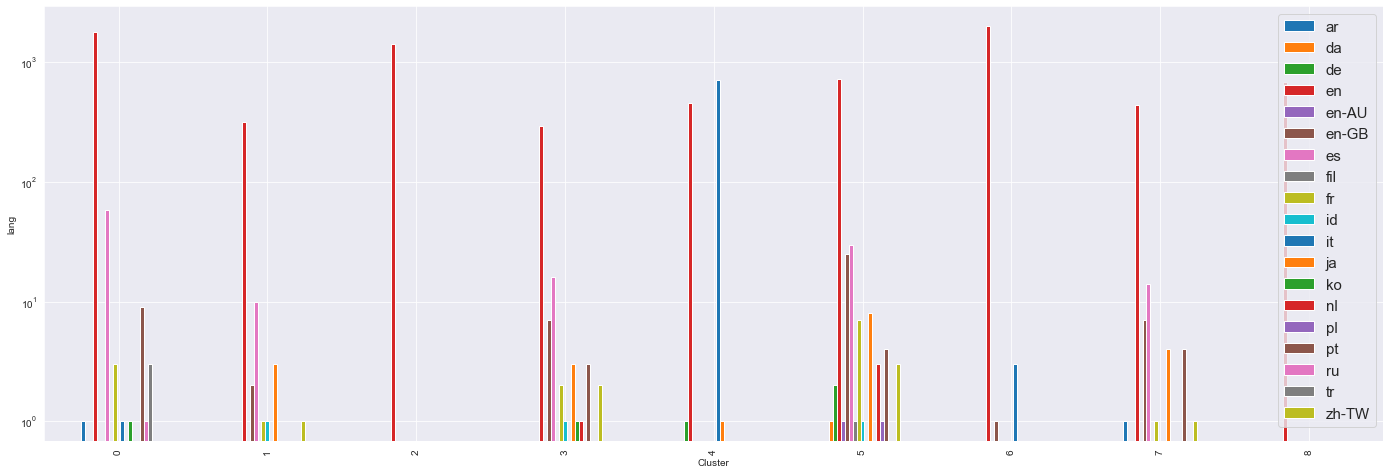

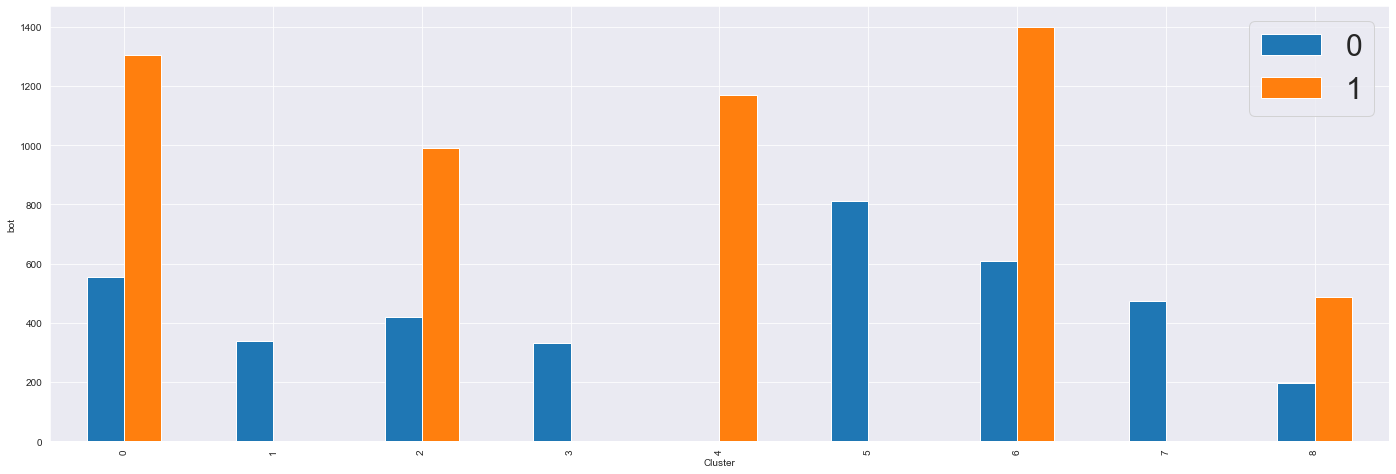

In [160]:
kmeans_analysis(df_denoised, k=9, out_dir='kmeans/denoised_k9')

SSE: 1359.7426716975021
17415.74207637504
8477.08459744022
14049.119671924827
11355.671451541453
12927.257681681605
8571.724054499266
19365.3465831868
13812.446024620063
24220.98644465777
20162.516355588166
mySSE: 150357.8949415152
Silouhette score: 0.3802244647588277
Davies Bouldin score: 1.0938880555845985


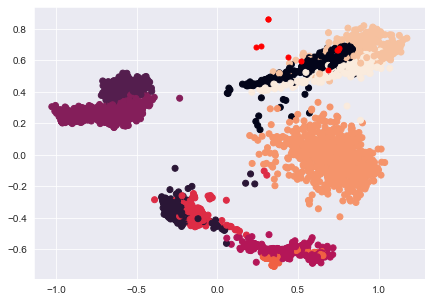

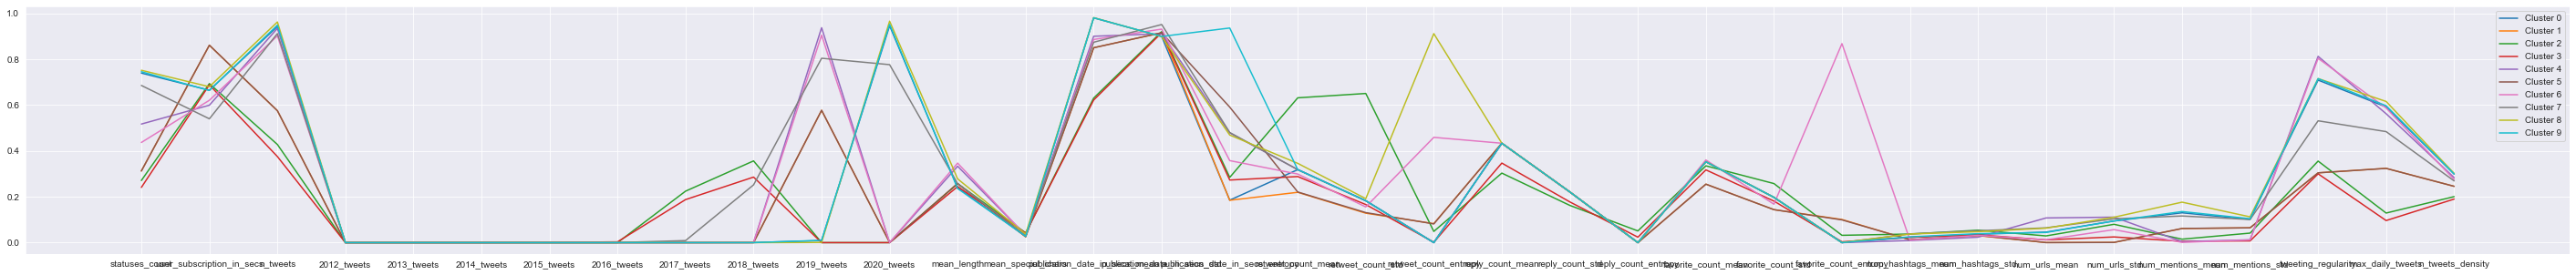

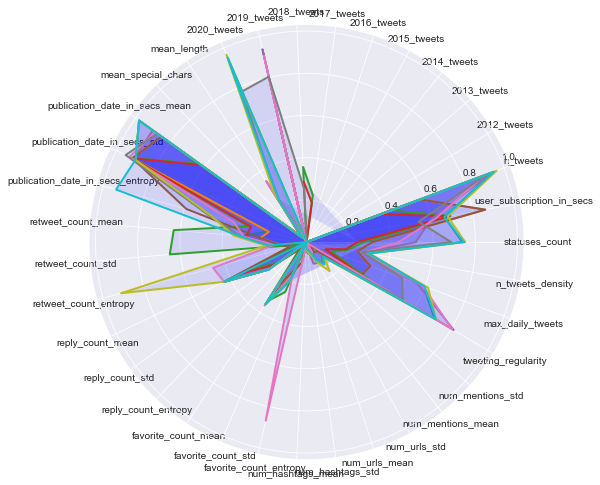

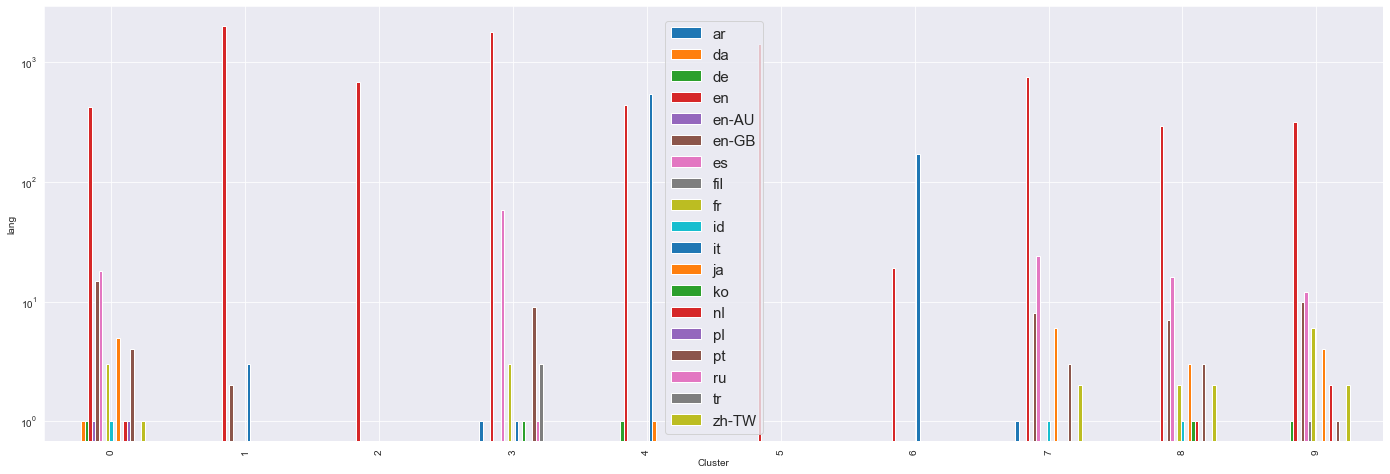

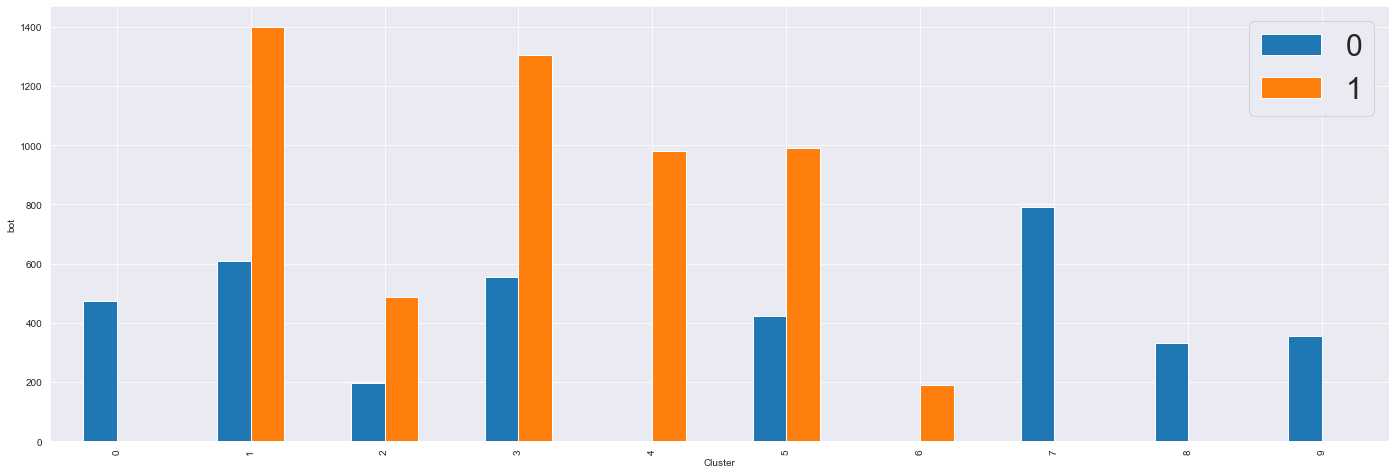

In [161]:
kmeans_analysis(df_denoised, k=10, out_dir='kmeans/denoised_k10')

# Hierarchical clustering

In [162]:
try:
  os.mkdir('hierarchical')
except FileExistsError:
  pass

In [163]:
df_merge_scaled[numeric_attributes].loc[[0,1,3]].mean()

statuses_count                      0.316112
user_subscription_in_secs           0.774885
n_tweets                            0.678863
2012_tweets                         0.000000
2013_tweets                         0.000000
2014_tweets                         0.000000
2015_tweets                         0.000000
2016_tweets                         0.000000
2017_tweets                         0.000000
2018_tweets                         0.000000
2019_tweets                         0.680968
2020_tweets                         0.000000
mean_length                         0.288375
mean_special_chars                  0.027144
publication_date_in_secs_mean       0.864359
publication_date_in_secs_std        0.918817
publication_date_in_secs_entropy    0.184220
retweet_count_mean                  0.245703
retweet_count_std                   0.140785
retweet_count_entropy               0.045242
reply_count_mean                    0.433457
reply_count_std                     0.220965
reply_coun

In [175]:
def hierarchical_analysis(df,metric, method, truncate_mode, p, n_clusters, directory, plot=False):
    df = df.reset_index()
    distances = pdist(df[numeric_attributes], metric=metric)
    dlinkage = linkage(distances, metric=metric, method=method)

    labels = fcluster(dlinkage,n_clusters,criterion='maxclust')
    if plot:
        try:
            os.mkdir(os.path.join('hierarchical',directory))
        except FileExistsError:
            pass

        dendrogram(dlinkage, truncate_mode=truncate_mode, p=p)
        plt.savefig(os.path.join('hierarchical',directory,"dendrogram.png"))
        plt.show()
        scatterplot(df[numeric_attributes+['pc1','pc2']], 'pc1','pc2',c_labels=labels,filename=os.path.join('hierarchical',directory, 'scatterplot.png'))

        plots(df, labels, os.path.join('hierarchical',directory), attributes=numeric_attributes)


    #print(f"SSE: {sse(df[numeric_attributes],labels)}")
    if len(labels) > 1:
        try:
            return get_metrics(df[numeric_attributes], labels, print_out=False)
        except:
            return 0,0
    else: return 0,0

In [176]:
def hierarchial_gs(df):
    table = PrettyTable(colums=['metric','method','truncation_mode','truncation_level','n_clustes','sse',])
    for metric in ['cityblock','correlation', 'cosine', 'dice', 'euclidean']:
        methods = ['complete','single','average','weighted']
        if metric == 'euclidean':
            methods += ['ward','median','centroid']
        for method in methods:
            for truncation_mode in [None, 'lastp','level']:
                for level in [2,3,4]:
                    for k in [7,8,9,10]:
                        metrics = hierarchical_analysis(df[numeric_attributes], metric, method, truncate_mode=truncation_mode, p=level, n_clusters=k,
                                                           directory=f'hierarchical/{metric}_{method}_{truncation_mode}_{level}_{k}')
                        table.add_row([metric, method, truncation_mode, level, k, *metrics])
    print(table)

This approach is tested on both noisy and denoised data.

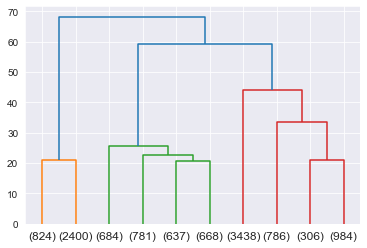

(0.3350518991309871, 1.610263818836256)

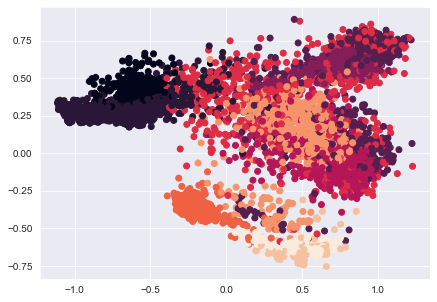

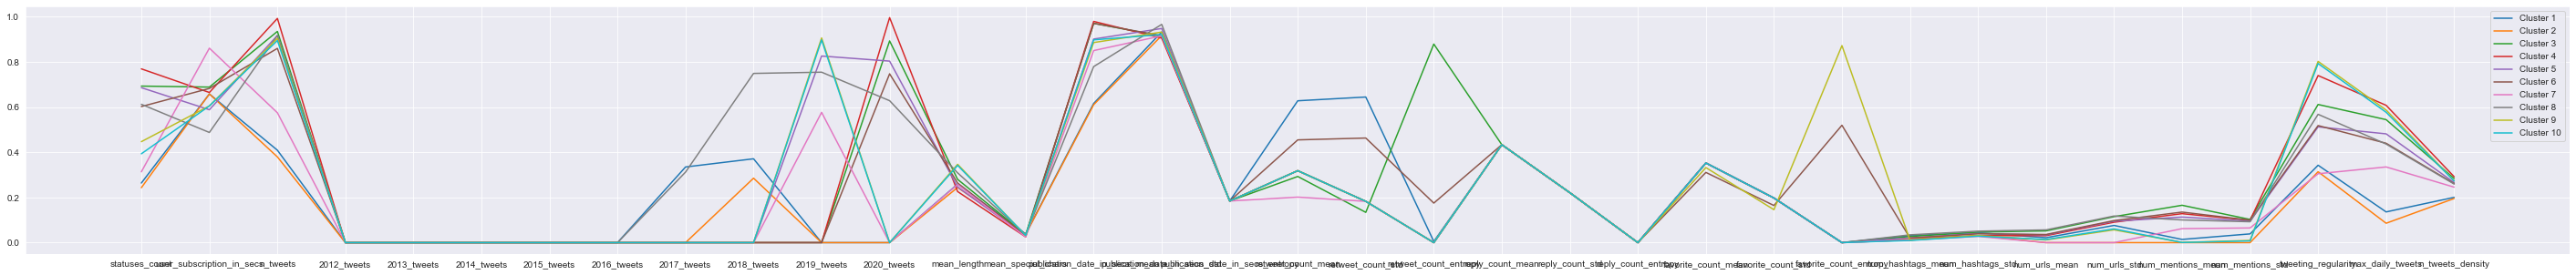

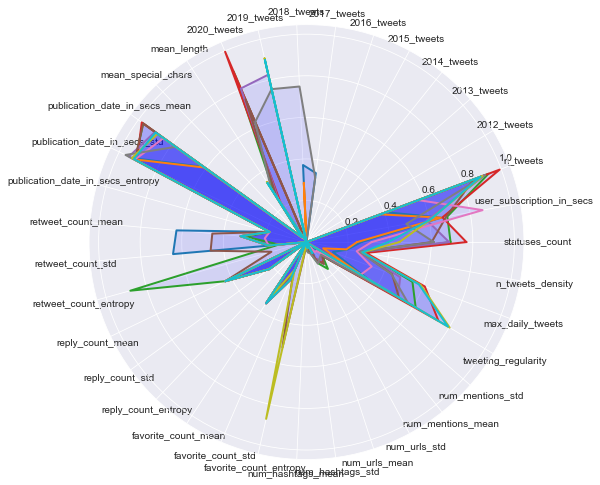

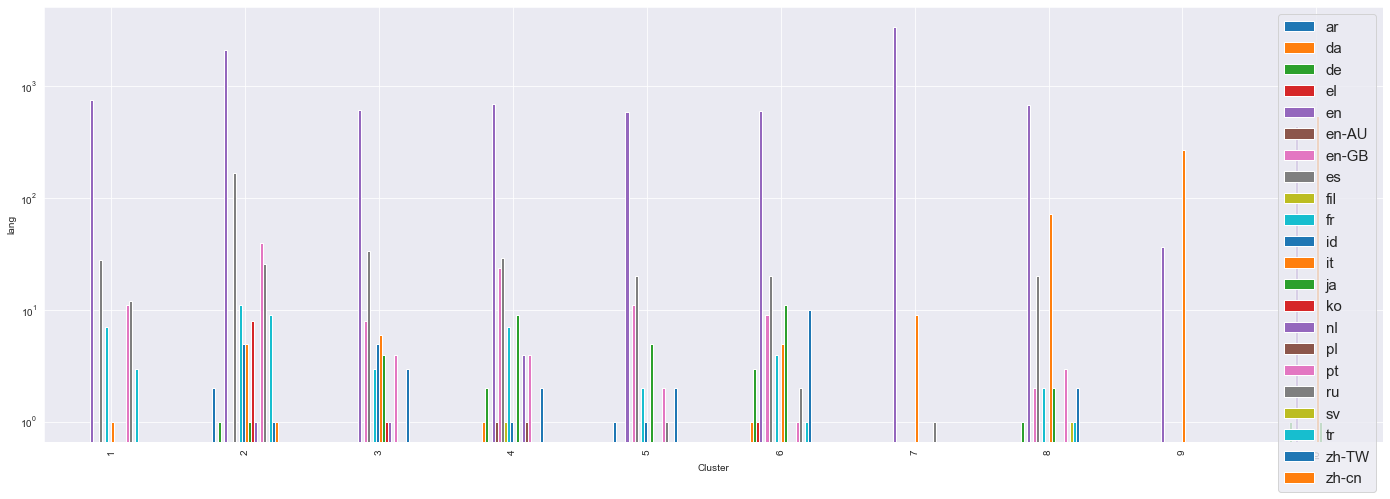

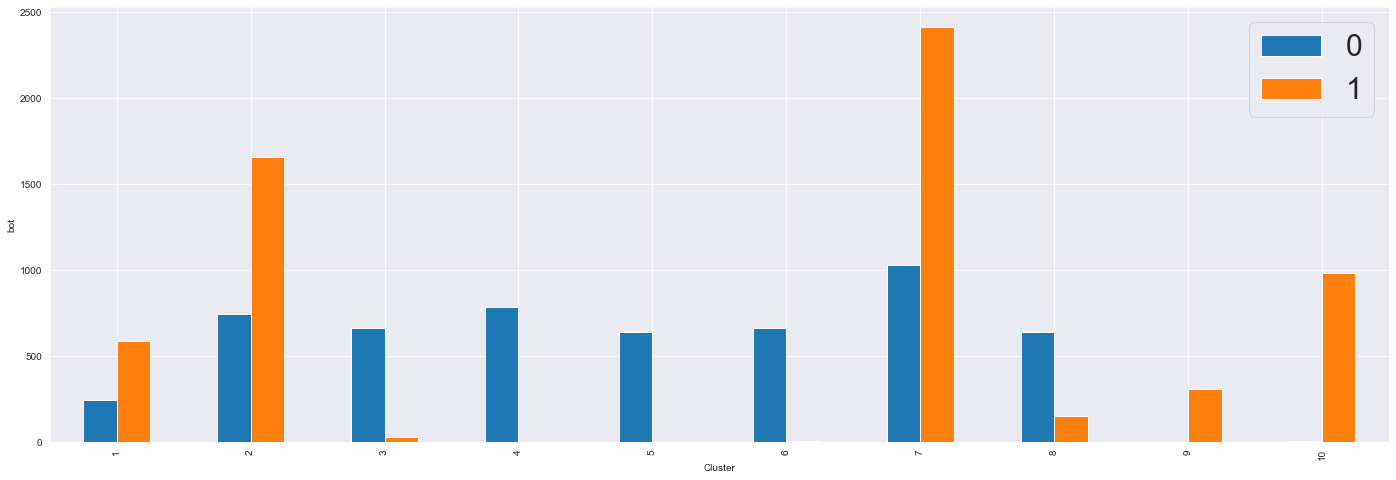

In [177]:
hierarchical_analysis(df_merge_scaled,'euclidean','ward','lastp',p=10,n_clusters=10,directory='euclidean_ward_k10_p4',plot=True)

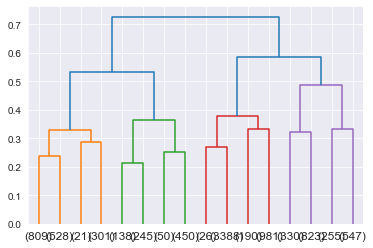

(0.3596655965579502, 1.385589026030311)

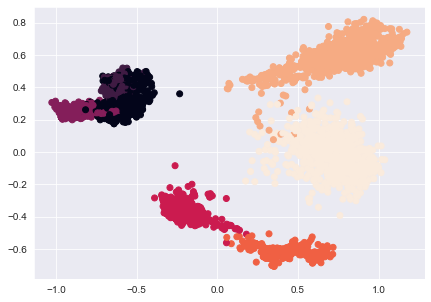

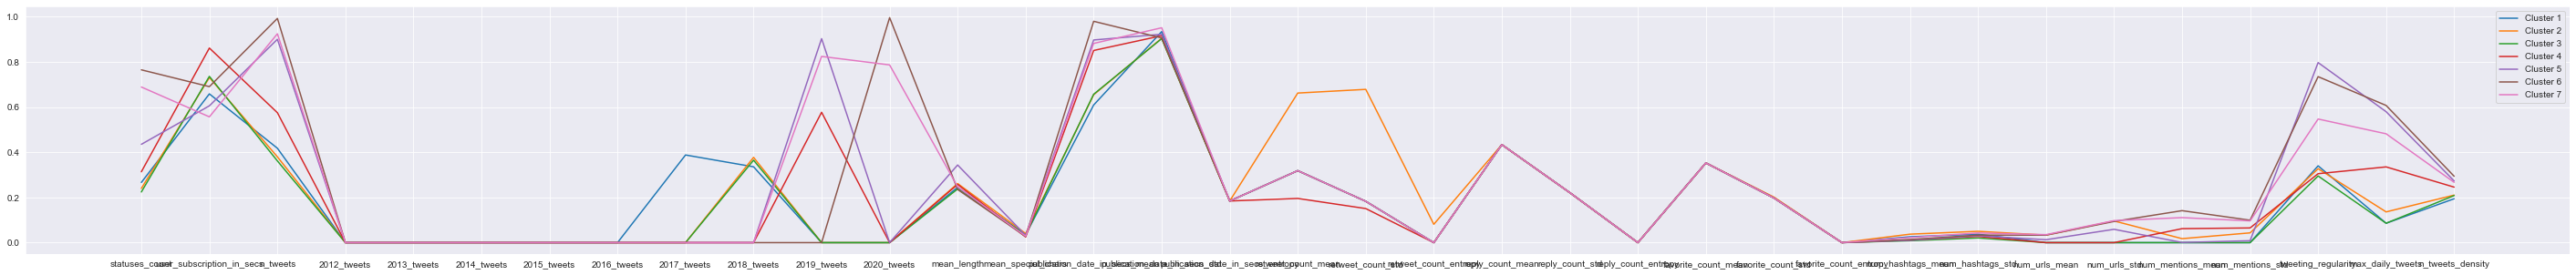

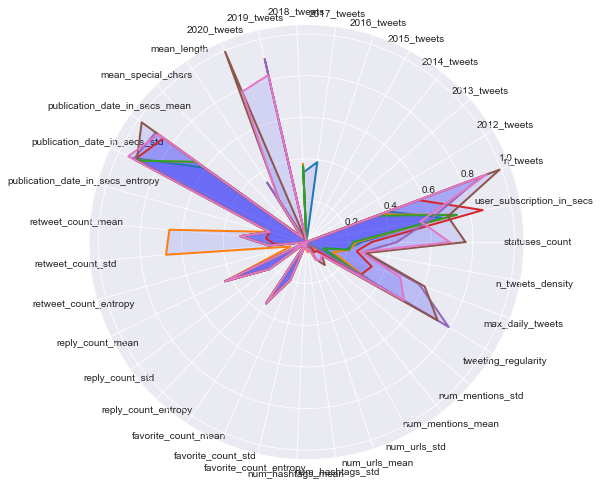

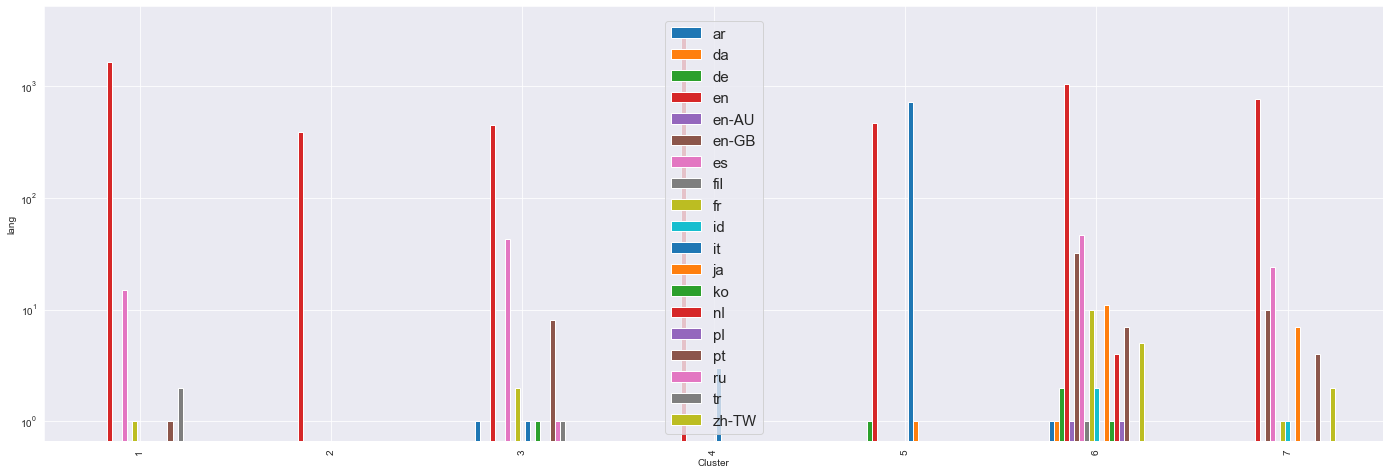

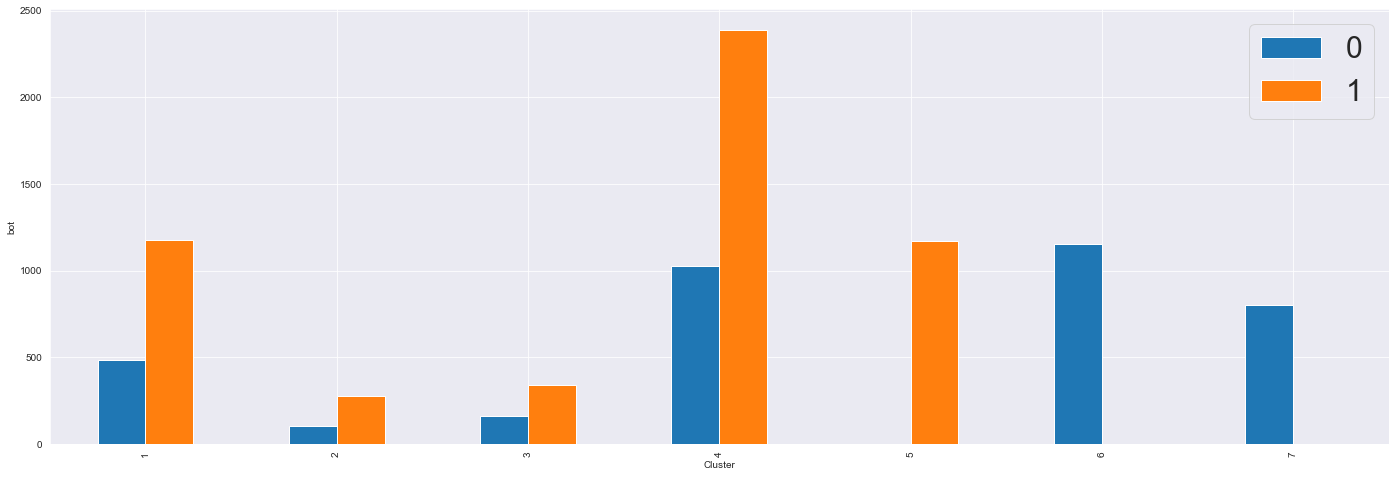

In [178]:
hierarchical_analysis(df_denoised,'correlation','complete','level',p=3,n_clusters=7,directory='denoised_correlation_k10',plot=True)

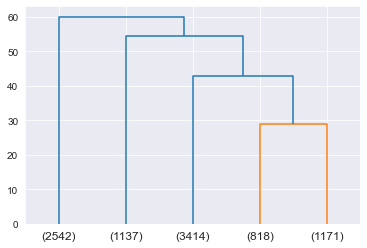

(0.4301934313202873, 1.2043641125326359)

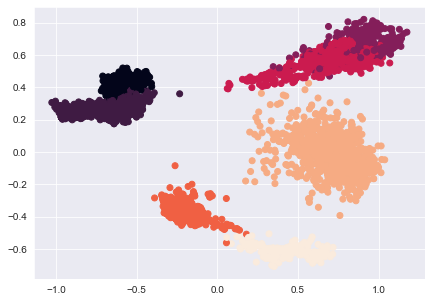

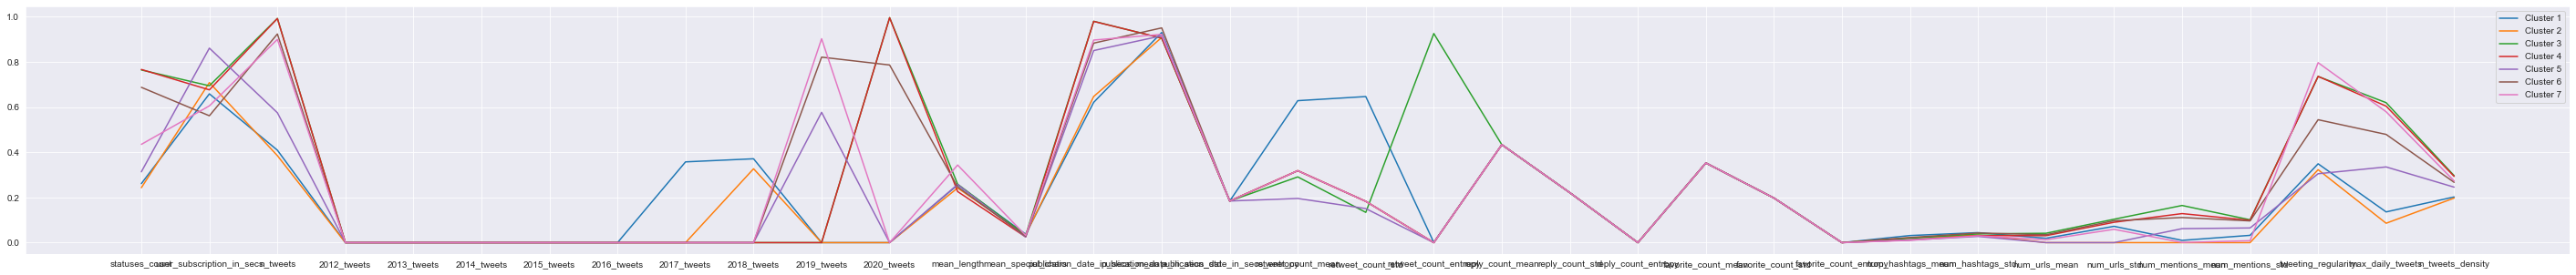

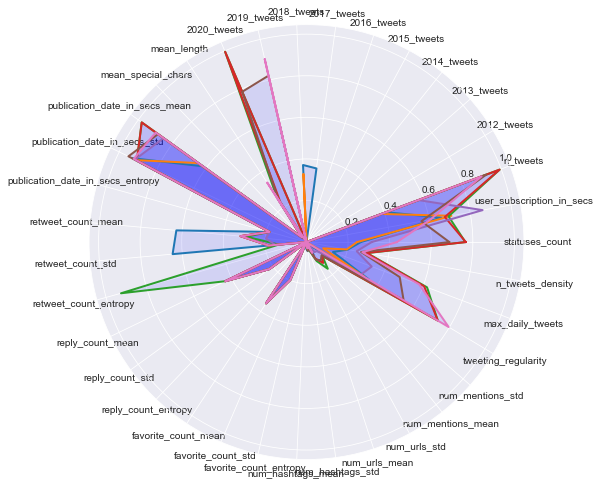

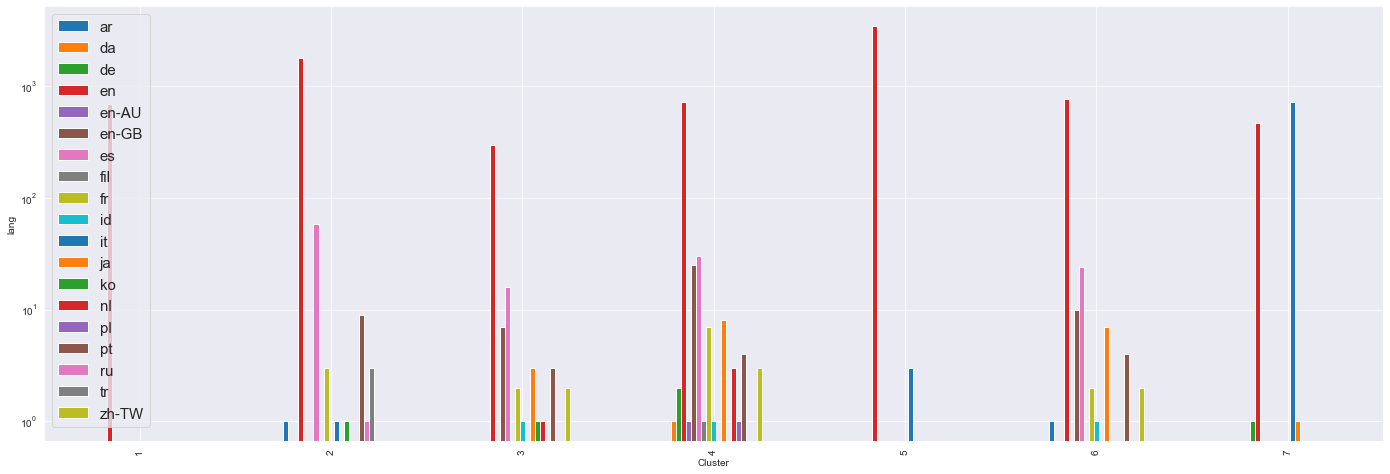

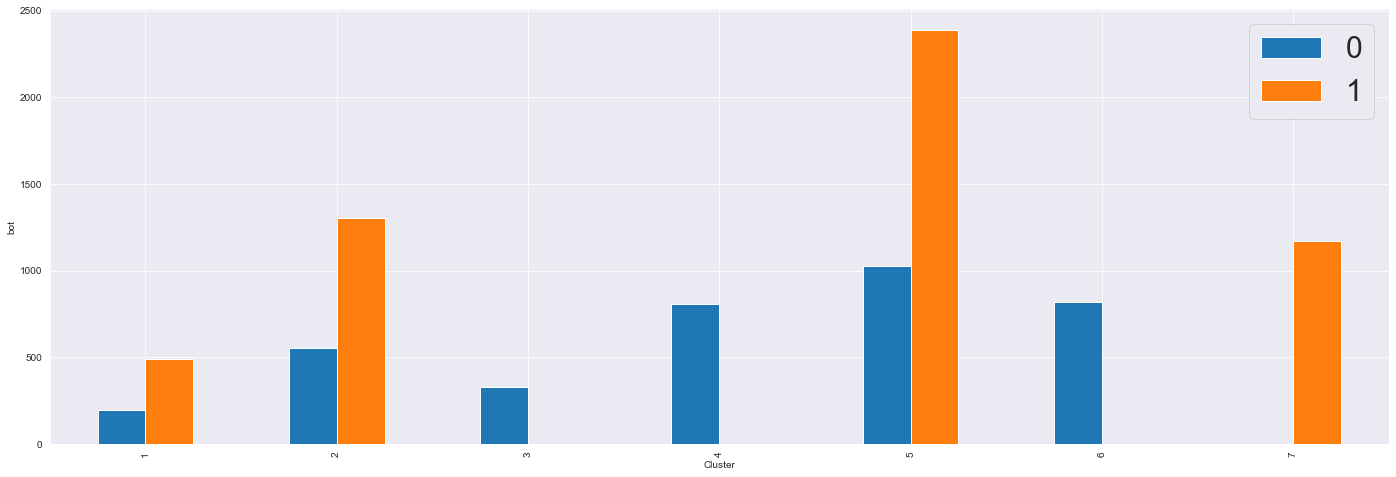

In [179]:
hierarchical_analysis(df_denoised,'euclidean','ward','lastp',p=5,n_clusters=7,directory='denoised_ward_k7',plot=True)

# Agglomerative clustering

In [181]:
def agglomerative_analysis(df, n_clusters, metric='euclidean', linkage='ward'):
    clusters = AgglomerativeClustering(affinity=metric, n_clusters=n_clusters, linkage=linkage)
    clusters.fit(df_merge_scaled[numeric_attributes])

    path=f'agglomerative/{metric}_{linkage}_k{n_clusters}/'
    get_metrics(df_merge_scaled[numeric_attributes], clusters.labels_)
    plots(df_merge_scaled, clusters.labels_, path=path, attributes=numeric_attributes)
    plt.show()
    scatterplot(df_merge_scaled, 'pc1', 'pc2', clusters.labels_,filename=os.path.join(path,'scatterplot.png'))

Silouhette score: 0.3350518991309871
Davies Bouldin score: 1.610263818836256


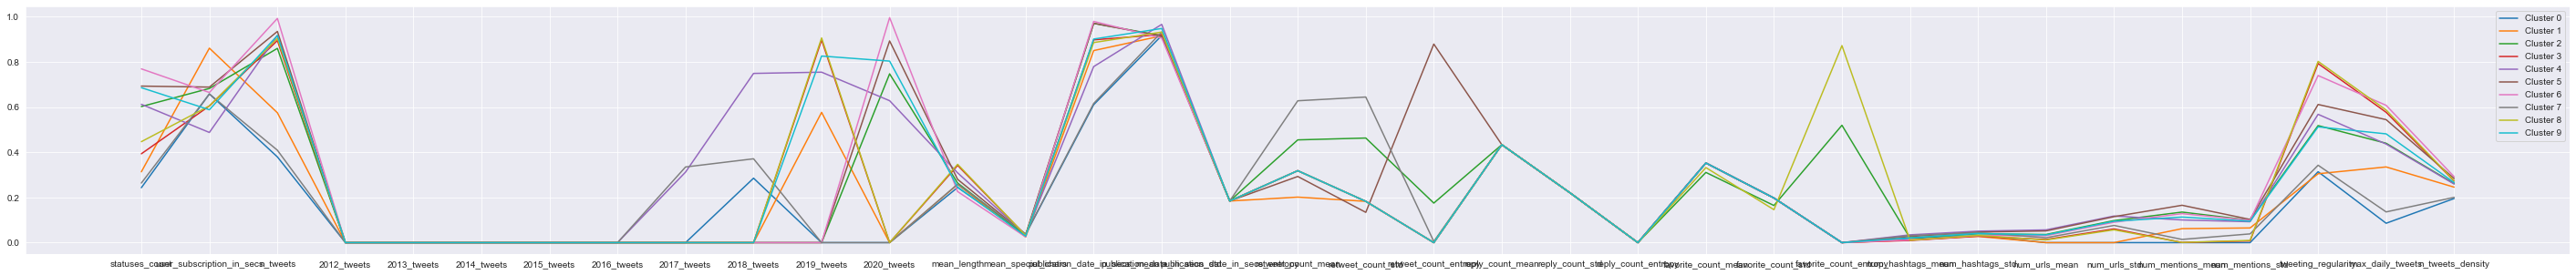

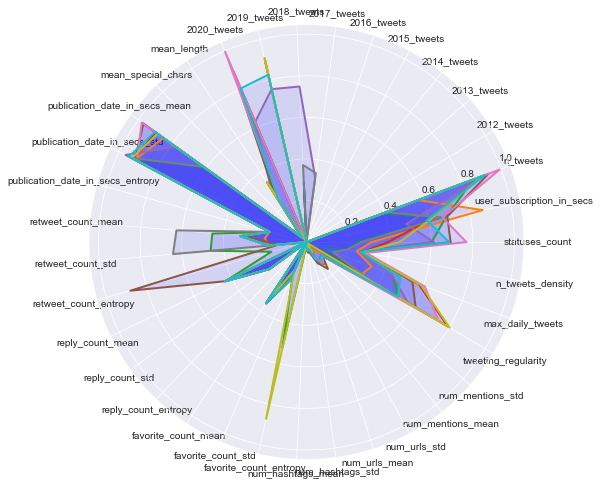

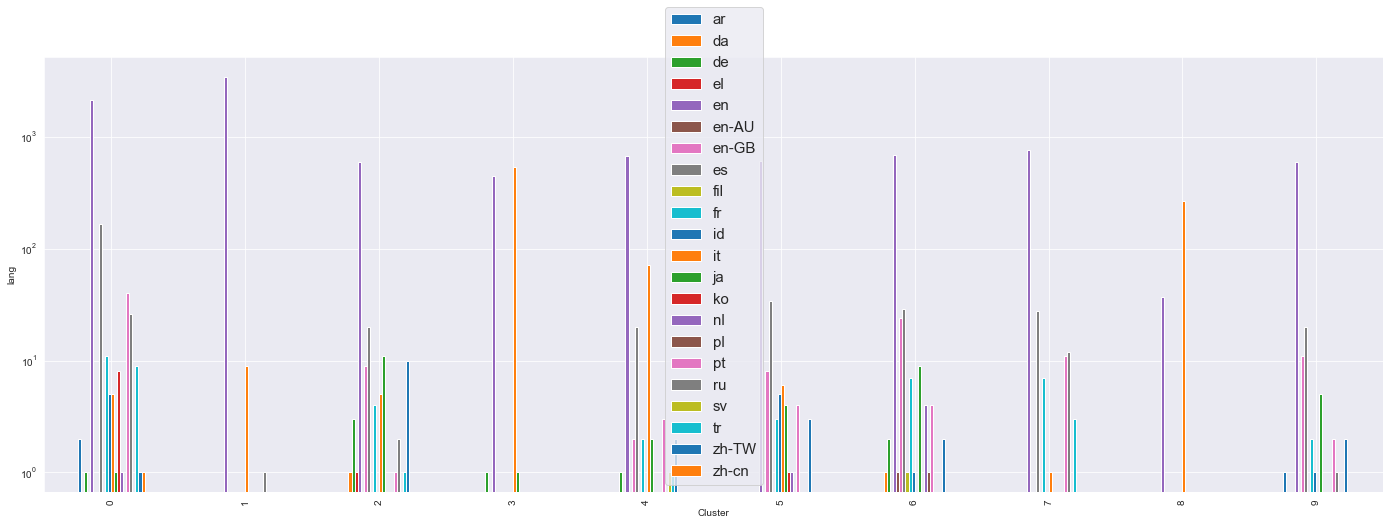

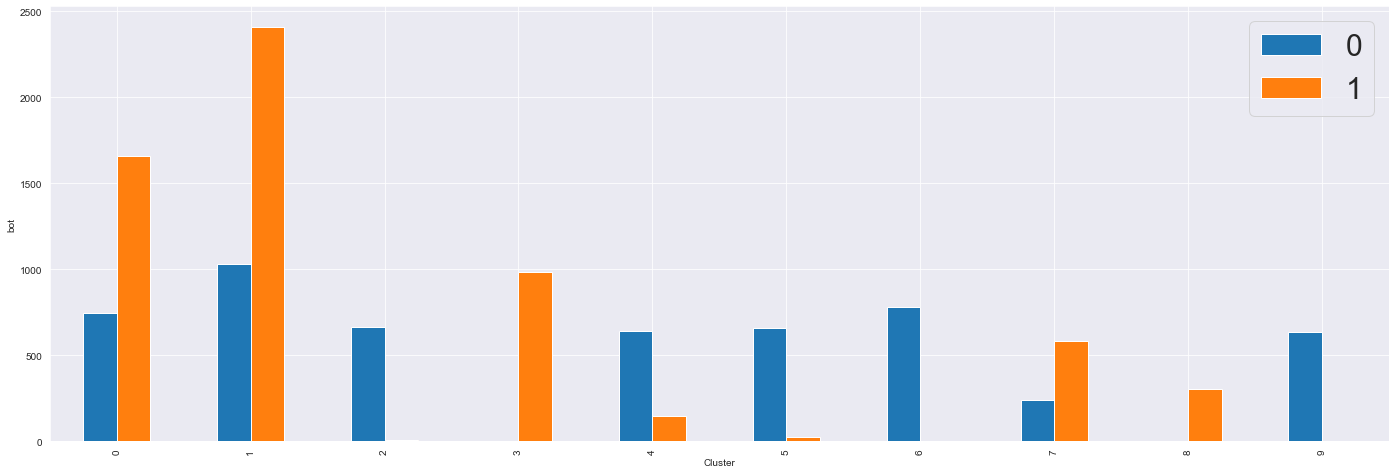

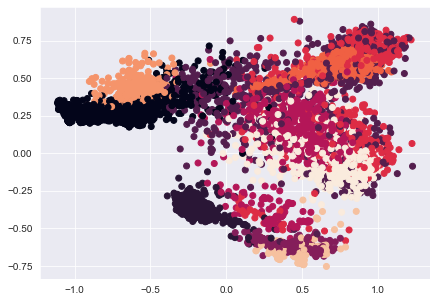

In [182]:
agglomerative_analysis(df_merge_scaled,10)

Silouhette score: 0.3257424538989405
Davies Bouldin score: 1.6144439581294594


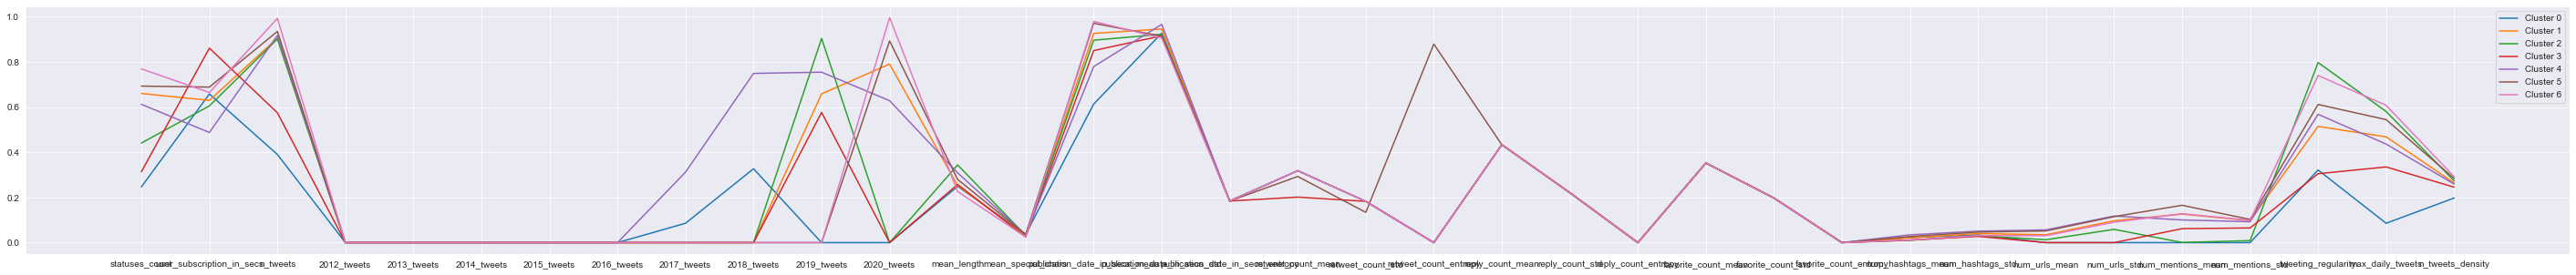

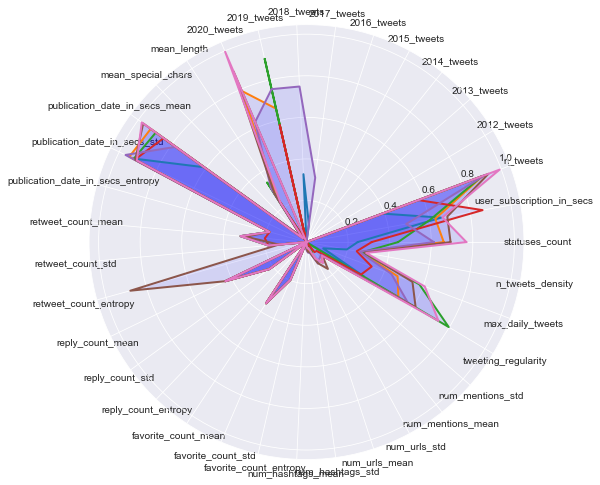

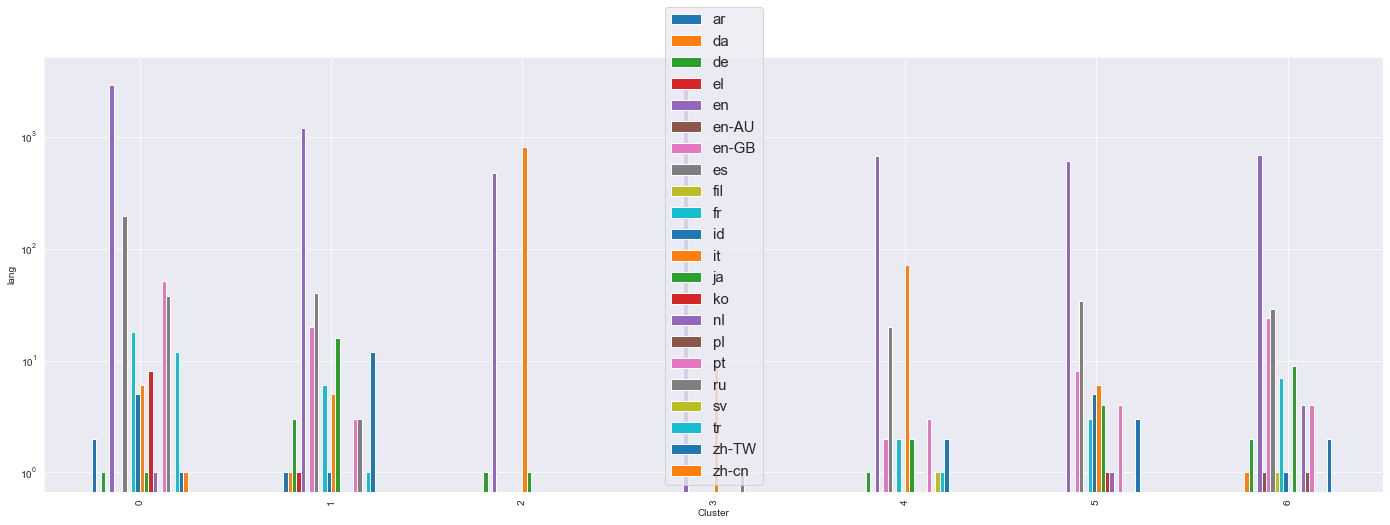

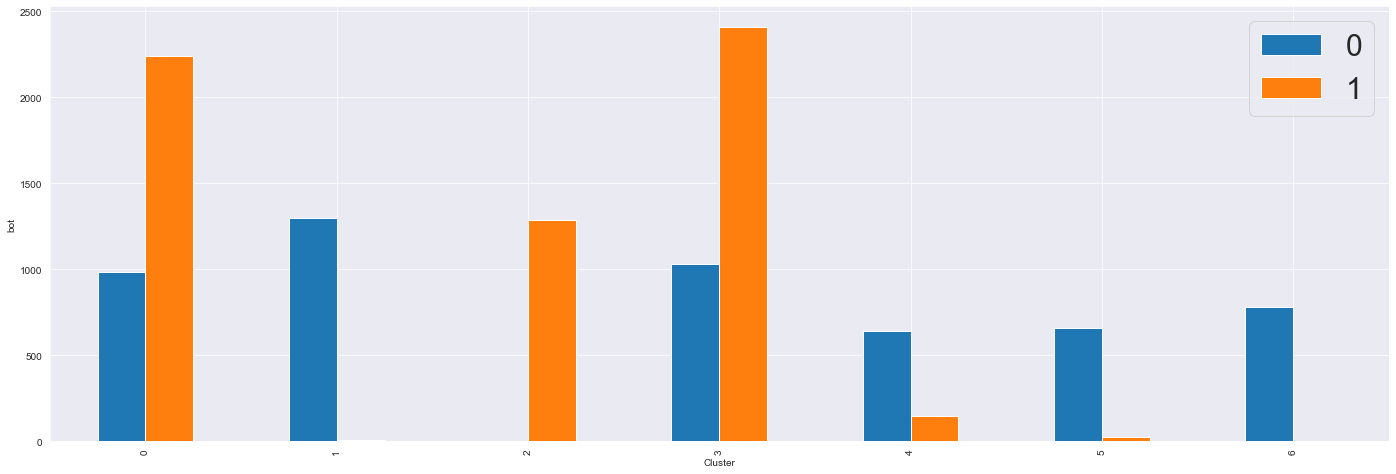

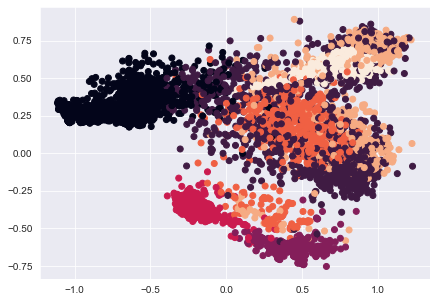

In [183]:
agglomerative_analysis(df_merge_scaled,7)

# X-Means

from https://github.com/annoviko/pyclustering/

In [ ]:
try:
  os.mkdir('xmeans')
except:
  pass

In [ ]:

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

k_start = 2
clusters_start = kmeans_plusplus_initializer(df_merge_scaled[numeric_attributes], 2).initialize()
 
# By defeault max # of clusters is 20, but we set it to 10
x_means = xmeans(df_merge_scaled[numeric_attributes], clusters_start, kmax=10, repeat=300) #, initial_centers, 20)
x_means.process()
 
# Extract clustering results: clusters and their centers
clusters = x_means.get_clusters()
centroids = x_means.get_centers()

print(f'Number of clusters found:', np.shape(centroids)[0])

In [ ]:
cluster_labels = dict()

''' 
Since for each cluster is saved the index in list of data
it is needed to convert it in such a way that
we have a list as long as the data, and in each
position it is saved the corresponding label for the
data with that index
'''
for label in range(0, np.shape(clusters)[0]):
  for i in range(0, len(clusters[label])):
    cluster_labels[clusters[label][i]] = label

cluster_labels = dict(sorted(cluster_labels.items()))

In [ ]:
print("SSE:", x_means.get_total_wce())
get_metrics(df_merge_scaled[numeric_attributes], list(cluster_labels.values()))

In [ ]:
plots(df_merge_scaled, np.array(list(cluster_labels.values())), path='xmeans', centroids=np.array(centroids), attributes = numeric_attributes)